In [425]:
# import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
from hijri_converter import Hijri, Gregorian

warnings.filterwarnings("ignore")

In [91]:
# load data 
transactions = pd.read_excel("../data/assesment_data.xlsx", sheet_name=0)

# standardize column names
transactions.rename(columns={"ID ":"ID", "Buyer Phone": "buyer_phone", 
                             "Grand Total": "grand_total", "Buyer City": "buyer_city", 
                             "Date":"date", "Status":"status"}, inplace=True)

# drop null values (only 9/~3000 instances)
transactions.dropna(axis=0, how="any", inplace=True)

# fix column type
transactions['buyer_phone'] = transactions.buyer_phone.astype("int")
transactions.head()

# delete below this line later
# fix tags in Status
mapper = {"Refunded":"refunded", "Delivered - Soum Product":"Transferred",
          "refunded":"refunded", "Transferred":"Transferred"}

transactions['status'] = transactions.status.apply(lambda x: mapper[x])

transactions.head()

,ID,date,status,buyer_phone,buyer_city,grand_total
0,1,2025-08-19,refunded,536047743,Riyadh,10849.950
1,3,2025-08-19,refunded,555755225,Riyadh,6630.525
2,4,2025-08-19,Transferred,551540834,Abha,8122.500
3,5,2025-08-19,Transferred,558411024,Abha,12671.100
4,6,2025-08-19,Transferred,509292218,Abha,7233.300


In [12]:
# take a glance at transactions
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2965
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           2957 non-null   int64         
 1   date         2957 non-null   datetime64[ns]
 2   status       2957 non-null   object        
 3   buyer_phone  2957 non-null   int64         
 4   buyer_city   2957 non-null   object        
 5   grand_total  2957 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 161.7+ KB


In [13]:
# load data from excel file
customers = pd.read_excel("../data/assesment_data.xlsx", sheet_name=1)
customers.rename(columns={"User ID":"ID", "mobileNumber":"customer_phone"}, inplace=True)
# drop null values (only 1/~80,000 instances)
customers.dropna(axis=0, how="any", inplace=True)
customers['customer_phone'] = customers.customer_phone.astype("int64")
customers.head()

,ID,customer_phone,createdDate,lastLoginDate
0,1,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z
1,2,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z
2,3,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z
3,4,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z
4,5,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z


In [14]:
# take a glance at customers
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82851 entries, 0 to 82851
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              82851 non-null  int64 
 1   customer_phone  82851 non-null  int64 
 2   createdDate     82851 non-null  object
 3   lastLoginDate   82851 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


* Prelimenary Data Quality Assessment

- No null values in either data frame (except 1 phone number)
- Data types are appropriate 
- 

Result 1: % of users who had 1+ transaction

Assumptions:
- There should be a unique 1-to-1 correspondence between phone numbers and user IDs. (turns out to be true almost)

In [15]:
# validate assumptions

customers.nunique()

ID                82851
customer_phone    82848
createdDate       82842
lastLoginDate     82848
dtype: int64

In [16]:
# find the number of unique users
n_customers = customers.customer_phone.nunique()

# find the number of customers who made at least one purchase
n_paying_customers = transactions.buyer_phone.nunique()

conversion_rate = n_paying_customers / n_customers
print("Conversion rate is {:.2f}%".format(conversion_rate * 100)) 

Conversion rate is 2.58%


Result 2: % of users who purchases their 2nd or 3rd transaction after a
refunded transaction vs of users who purchases their 2nd or 3rd  after transferred
one

Assumptions:
- There are either transfered transactions or refunded transactions
- The date column is sorted in ascending order

In [17]:
# validate assumptions

transactions.status.value_counts()

Transferred    1565
refunded       1392
Name: status, dtype: int64

- We can fix this problem by lumping together the entries of refunded transactions. 
- However, it is more difficult to make sense of the meaning of "Delivered - Soum Product." 
- Since we can't ask colleagues to confirm that those entries indicate items that were in fact delivered to satisfied customers, we will lump them with the "Transferred" column and hope we don't produce any bias. 

In [92]:
# fix tags in Status
mapper = {"Refunded":"refunded", "Delivered - Soum Product":"Transferred",
          "refunded":"refunded", "Transferred":"Transferred"}

transactions['status'] = transactions.status.apply(lambda x: mapper[x])

# confirm fix
transactions.status.value_counts()

Transferred    1565
refunded       1392
Name: status, dtype: int64

In [19]:
# group

groups = transactions.groupby(["buyer_phone"])

# number of first-time buyers who returned the device
n_refund_first_time = 0
# number of first-time buyers who accepted the device
n_accept_first_time = 0
# number of second-time buyers who returned the device in their first purchase
n_returned_after_refund = 0
# number of second-time buyers who accepted the device in their first purchase
n_returned_after_accept = 0

for buyer_phone, group in groups:
    # the first-time purchase is always at the top of the group
    status_first_purchase = group.iloc[0]['status']
    accepted = status_first_purchase == "Transferred"
    returning_customer = group.shape[0] > 1
    loyal_customer = group.shape[0] > 2
    
    # make the below loops a separate function
    
    if accepted:
        n_accept_first_time += 1
        if returning_customer:
            n_returned_after_accept += 1
    else:
        n_refund_first_time += 1
        if returning_customer:
            n_returned_after_refund +=1

In [20]:
# create new attribute to assess the behavior of customers

def get_behavior(customers, record_length = 3):
    """

    Args:
        customers (pd.DataFrame.groups): collection of data frames, one 
        for each customer who made a purchase. The purchases of a customer
        are ordered chronologically.
        
        record_length (int): number of purchases to keep track of

    Returns:
        pd.Series[(int, boolean, boolean, boolean)]: series indicating if
        the customer accepted the product he/she purchased; null if purchase
        was never made.
    """

    customers_behavior = {}
    # purchase_record = pd.Series(np.repeat(np.nan, record_length))
    
    for buyer_number, purchases in customers:
        # purchase_record = pd.Series(np.repeat(np.nan, record_length))
        purchase_record = []
        n_purchases = purchases.shape[0]            
        # if n_purchases < 3:
        #     continue
        # print(n_purchases)
        # print(purchases.status)
        accepted = purchases.status == "Transferred"
        # print(accepted)
        n_tracked = min(n_purchases, record_length)
        purchase_record[0:n_tracked] = accepted[0:n_tracked]
        # print(n_tracked)
        # print(purchase_record)
        try:
            purchase_record = purchase_record + list(np.repeat(None, record_length - n_tracked))
        except:
            print(purchase_record)
            print(np.repeat(None, record_length - n_purchases))
            print(purchase_record + list(np.repeat(None, record_length - n_tracked)))
        
        # print(purchase_record)
        # print("Next iteration ***")
        customers_behavior[buyer_number] = purchase_record
    
    return customers_behavior

In [21]:
groups = transactions.groupby(["buyer_phone"])
results = get_behavior(groups, 3)
results

{500421154: [False, None, None],
 500980006: [True, None, None],
 502118629: [False, None, None],
 502192244: [False, None, None],
 502378158: [False, None, None],
 502679041: [True, None, None],
 503779121: [False, None, None],
 504557661: [True, None, None],
 504971633: [True, None, None],
 508375678: [True, None, None],
 508383480: [False, True, None],
 508388156: [True, None, None],
 508404362: [False, None, None],
 508417788: [True, None, None],
 508434828: [False, None, None],
 508448858: [False, None, None],
 508460413: [False, True, None],
 508579577: [True, True, None],
 508621477: [False, None, None],
 508636501: [True, None, None],
 508716106: [False, None, None],
 508721049: [True, None, None],
 508787918: [False, None, None],
 508840193: [True, None, None],
 508853583: [False, None, None],
 508867125: [True, False, None],
 508873010: [True, False, True],
 508874308: [False, None, None],
 508907180: [False, True, True],
 508932586: [False, None, None],
 508934958: [True, No

In [22]:
lst = []
lst[0:2] = [False, False]
lst + [None]

[False, False, None]

In [23]:
results

{500421154: [False, None, None],
 500980006: [True, None, None],
 502118629: [False, None, None],
 502192244: [False, None, None],
 502378158: [False, None, None],
 502679041: [True, None, None],
 503779121: [False, None, None],
 504557661: [True, None, None],
 504971633: [True, None, None],
 508375678: [True, None, None],
 508383480: [False, True, None],
 508388156: [True, None, None],
 508404362: [False, None, None],
 508417788: [True, None, None],
 508434828: [False, None, None],
 508448858: [False, None, None],
 508460413: [False, True, None],
 508579577: [True, True, None],
 508621477: [False, None, None],
 508636501: [True, None, None],
 508716106: [False, None, None],
 508721049: [True, None, None],
 508787918: [False, None, None],
 508840193: [True, None, None],
 508853583: [False, None, None],
 508867125: [True, False, None],
 508873010: [True, False, True],
 508874308: [False, None, None],
 508907180: [False, True, True],
 508932586: [False, None, None],
 508934958: [True, No

In [24]:
customer_597635265 = transactions.query("buyer_phone == 597635265")
n_transactions = customer_597635265.shape[0]
customer_597635265[['purchase_1', 'purchase_2', 'purchase_3']] = np.tile(results[597635265], (n_transactions, 1))
print(customer_597635265)
# print(results[597635265])

        ID                    date       status  buyer_phone    buyer_city  \
85     107 2025-08-29 00:00:00.000  Transferred    597635265       Al Baha   
1159  1425 2025-10-19 00:00:00.000     refunded    597635265  Ras Tannurah   
1981  2405 2025-11-17 11:53:00.096     refunded    597635265        Riyadh   
2958  3600 2025-12-13 12:15:59.904  Transferred    597635265        Jeddah   

      grand_total  purchase_1  purchase_2  purchase_3  
85        1598.28        True       False       False  
1159      7552.50        True       False       False  
1981      8165.25        True       False       False  
2958      3201.12        True       False       False  


In [25]:
n_transactions = (transactions.buyer_phone == 597635265).sum()
transactions.loc[transactions.buyer_phone == 597635265][['purchase_1', 'purchase_2', 'purchase_3']] = np.tile(results[597635265], (n_transactions, 1))
transactions.loc[transactions.buyer_phone == 597635265]
np.tile(results[597635265], (n_transactions, 1))

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [ True, False, False]])

In [26]:
# add new attributes
df_new = pd.DataFrame({"buyer_phone":[],"purchase_1":[], "purchase_2":[], "purchase_3":[]})

for buyer_phone, past_behavior in results.items():

    df_new = df_new.append(pd.Series([buyer_phone]+past_behavior), ignore_index=True)
# transactions.head(10)    


In [27]:
df_new.columns

Index(['buyer_phone', 'purchase_1', 'purchase_2', 'purchase_3', 0, 1, 2, 3], dtype='object')

In [28]:
df_new.iloc[:,0:4] = df_new.iloc[:,4:]
df_new.drop(columns=[0,1,2,3], inplace=True)
df_new['buyer_phone'] = df_new.buyer_phone.astype('int')
df_new

,buyer_phone,purchase_1,purchase_2,purchase_3
0,500421154,False,None,None
1,500980006,True,None,None
2,502118629,False,None,None
3,502192244,False,None,None
4,502378158,False,None,None
...,...,...,...,...
2133,599934906,True,False,None
2134,599937027,True,None,None
2135,599940833,True,None,None
2136,599976770,False,None,None


In [29]:
# transactions.drop(columns=['purchase_1',	'purchase_2', 'purchase_3'], inplace=True)
purchase_df = transactions.merge(df_new, 'right', on='buyer_phone')
# transactions[['purchase_1',	'purchase_2', 'purchase_3']].sum()
purchase_df

,ID,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.000,False,None,None
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.830,True,None,None
2,3250,2025-12-07 12:15:59.904,refunded,502118629,Khobar,30.153,False,None,None
3,3126,2025-12-05 00:00:00.000,refunded,502192244,Dammam,20795.766,False,None,None
4,3325,2025-12-08 23:15:59.616,refunded,502378158,Rafha,5033.157,False,None,None
...,...,...,...,...,...,...,...,...,...
2952,1840,2025-11-02 17:28:00.192,refunded,599934906,Rafha,17128.500,True,False,None
2953,1038,2025-10-11 00:00:00.000,Transferred,599937027,Riyadh,4354.230,True,None,None
2954,3460,2025-12-11 12:15:59.904,Transferred,599940833,Jeddah,8961.825,True,None,None
2955,873,2025-10-05 00:00:00.000,refunded,599976770,Tabuk,10830.000,False,None,None


In [474]:
# analyze the purchase behavior of our customers
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2956
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     2957 non-null   int64         
 1   date                   2957 non-null   datetime64[ns]
 2   status                 2957 non-null   object        
 3   buyer_phone            2957 non-null   int64         
 4   buyer_city             2957 non-null   object        
 5   grand_total            2957 non-null   float64       
 6   purchase_1             2957 non-null   object        
 7   purchase_2             1179 non-null   object        
 8   purchase_3             721 non-null    object        
 9   makes_second_purchase  2957 non-null   bool          
 10  purchase_1_status      2957 non-null   object        
 11  purchase_2_status      1179 non-null   object        
 12  purchase_3_status      721 non-null    object        
 13  mak

In [31]:
# percentage of acceptance of first purchase
n1 = purchase_df.purchase_1.count()
n2 = purchase_df.purchase_2.count()
n3 = purchase_df.purchase_3.count()
purchase_df.purchase_1.sum() / n1
# percentage of acceptance of second purchase
purchase_df.purchase_2.sum() / n2
# percentage of acceptance of third purchase
purchase_df.purchase_3.sum() / n3

0.6130374479889042

In [32]:
# 
purchase_df.loc[purchase_df.purchase_3 == True].purchase_1.sum() / purchase_df.loc[purchase_df.purchase_3 == True].purchase_1.count()

0.5701357466063348

In [ ]:
returning_customer_after_refund = n_returned_after_refund / n_refund_first_time
returning_customer_after_accept = n_returned_after_accept / n_accept_first_time

print("When a customer refunds their first purchase, there is a {:.1f}% chance they will make a second purchase.".format(returning_customer_after_refund * 100))
print("When a customer accepts their first purchase, there is a {:.1f}% chance they will make a second purchase.".format(returning_customer_after_accept * 100))

When a customer refunds their first purchase, there is a 16.7% chance they will make a second purchase.
When a customer accepts their first purchase, there is a 17.0% chance they will make a second purchase.


In [ ]:
# # find p value to determine whether the difference is due to chance
# import statsmodels.api as sm

# df_old = df2.query("landing_page=='old_page'")
# df_new = df2.query("landing_page=='new_page'")

# convert_old = df_old.converted.sum() / df_old.converted.size
# convert_new = df_new.converted.sum() / df_new.converted.size
# n_old = df_old.shape[0]
# n_new = df_new.shape[0]

# convert_old, convert_new, n_old, n_new 

In [ ]:
# result = sm.stats.proportions_ztest(count=convert_old, nobs=n_old, value=0)

# z_test = result[0]
# p_value = result[1]

# z_test, p_value

In [81]:
mapper = {True:'Accepted', False:'Returned'}
purchase_df['purchase_1_status'] = purchase_df.purchase_1.apply(lambda x: mapper[x])
purchase_df['purchase_2_status'] = purchase_df.purchase_2.apply(lambda x: mapper[x] if not pd.isna(x) else None)
purchase_df['purchase_3_status'] = purchase_df.purchase_3.apply(lambda x: mapper[x] if not pd.isna(x) else None)
purchase_df.head(2)

,ID,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3,makes_second_purchase,purchase_1_status,purchase_2_status,purchase_3_status
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.00,False,None,None,False,Returned,None,None
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.83,True,None,None,False,Accepted,None,None


In [79]:
purchase_df

,ID,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3,makes_second_purchase,purchase_1_status
0,3419,2025-12-10 12:15:59.904,refunded,500421154,Jeddah,4332.000,False,None,None,False,Returned
1,3064,2025-12-04 00:00:00.000,Transferred,500980006,Riyadh,5425.830,True,None,None,False,Accepted
2,3250,2025-12-07 12:15:59.904,refunded,502118629,Khobar,30.153,False,None,None,False,Returned
3,3126,2025-12-05 00:00:00.000,refunded,502192244,Dammam,20795.766,False,None,None,False,Returned
4,3325,2025-12-08 23:15:59.616,refunded,502378158,Rafha,5033.157,False,None,None,False,Returned
...,...,...,...,...,...,...,...,...,...,...,...
2952,1840,2025-11-02 17:28:00.192,refunded,599934906,Rafha,17128.500,True,False,None,True,Accepted
2953,1038,2025-10-11 00:00:00.000,Transferred,599937027,Riyadh,4354.230,True,None,None,False,Accepted
2954,3460,2025-12-11 12:15:59.904,Transferred,599940833,Jeddah,8961.825,True,None,None,False,Accepted
2955,873,2025-10-05 00:00:00.000,refunded,599976770,Tabuk,10830.000,False,None,None,False,Returned


In [87]:
# correct way to do a groupby; make sure not to count same customers multiple times
purchase_df_unique = purchase_df.loc[~ purchase_df.buyer_phone.duplicated()]
purchase_df_unique.groupby(['purchase_1', 'purchase_2']).count()['ID']

purchase_1  purchase_2
False       False          83
            True           88
True        False          79
            True          110
Name: ID, dtype: int64

In [85]:
purchase_df['makes_second_purchase'] = ~ purchase_df.purchase_2.isna()
purchase_df['makes_third_purchase'] = ~ purchase_df.purchase_3.isna()
# purchase_df.groupby(['purchase_1', 'purchase_2']).count()['ID']
purchase_df.loc[~ purchase_df.buyer_phone.duplicated()].groupby(['purchase_1', 'makes_second_purchase']).count()['ID'] 

purchase_1  makes_second_purchase
False       False                    853
            True                     171
True        False                    925
            True                     189
Name: ID, dtype: int64

In [93]:
result = purchase_df_unique.groupby('purchase_1_status').apply(lambda x:  x.makes_second_purchase.value_counts() * 100 / float(x.shape[0]))
result

makes_second_purchase,False,True
purchase_1_status,,
Accepted,83.034111,16.965889
Returned,83.300781,16.699219


In [156]:
result = purchase_df_unique.groupby(['purchase_1_status', 'purchase_2_status']).apply(lambda x:  x.makes_third_purchase.value_counts() / float(x.shape[0]))
print("""% of users who purchases their 2nd or 3rd transaction after a refunded transaction 
      vs of users who purchases their 2nd or 3rd  after transferred one""")
result

% of users who purchases their 2nd or 3rd transaction after a refunded transaction 
      vs of users who purchases their 2nd or 3rd  after transferred one


makes_third_purchase                    False      True
purchase_1_status purchase_2_status                    
Accepted          Accepted           0.690909  0.309091
                  Returned           0.594937  0.405063
Returned          Accepted           0.625000  0.375000
                  Returned           0.614458  0.385542

In [160]:
result = purchase_df_unique.groupby(['purchase_1_status', 'purchase_2_status']).apply(lambda x:  x.purchase_3_status.value_counts() / float(x.purchase_3_status.count()))
print("""% of users who purchases their 2nd or 3rd transaction after a refunded transaction 
      vs of users who purchases their 2nd or 3rd  after transferred one""")
result

% of users who purchases their 2nd or 3rd transaction after a refunded transaction 
      vs of users who purchases their 2nd or 3rd  after transferred one


purchase_3_status                    Accepted  Returned
purchase_1_status purchase_2_status                    
Accepted          Accepted           0.529412  0.470588
                  Returned           0.656250  0.343750
Returned          Accepted           0.515152  0.484848
                  Returned           0.687500  0.312500

In [165]:
result = purchase_df_unique.groupby(['buyer_city']).apply(lambda x:  
    x.makes_second_purchase.value_counts() / float(x.makes_second_purchase.count()))

print("""% of users who purchases their 2nd or 3rd transaction after a refunded transaction 
      vs of users who purchases their 2nd or 3rd  after transferred one""")
result

% of users who purchases their 2nd or 3rd transaction after a refunded transaction 
      vs of users who purchases their 2nd or 3rd  after transferred one


makes_second_purchase,False,True
buyer_city,,
Abha,0.735849,0.264151
Al Baha,0.840000,0.160000
Al Qassim,0.839450,0.160550
Dammam,0.866667,0.133333
Jeddah,0.838983,0.161017
Khobar,0.826923,0.173077
Makkah,0.819672,0.180328
Rafha,0.870968,0.129032
Ras Tannurah,0.848780,0.151220


In [ ]:
state_pcts = state_office.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [49]:
purchase_df.loc[~ purchase_df.buyer_phone.duplicated()].groupby('purchase_1')['makes_second_purchase'].count()

purchase_1
False    1024
True     1114
Name: makes_second_purchase, dtype: int64

In [59]:
# From Paul H
import numpy as np
import pandas as pd
np.random.seed(0)
df = pd.DataFrame({'state': ['CA', 'WA', 'CO', 'AZ'] * 3,
                   'office_id': list(range(1, 7)) * 2,
                   'sales': [np.random.randint(100000, 999999)
                             for _ in range(12)]})
state_office = df.groupby(['state', 'office_id']).agg({'sales': 'sum'})
# Change: groupby state_office and divide by sum
state_pcts = state_office.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))


In [55]:
df.groupby(['state', 'office_id'])['sales']

In [53]:
df

,state,office_id,sales
0,CA,1,405711
1,WA,2,535829
2,CO,3,217952
3,AZ,4,252315
4,CA,5,982371
5,WA,6,459783
6,CO,1,404137
7,AZ,2,222579
8,CA,3,710581
9,WA,4,548242


In [58]:
state_office = df.groupby(['state', 'office_id']).mean()['sales']

state_office

state  office_id
AZ     2            222579.0
       4            252315.0
       6            835831.0
CA     1            405711.0
       3            710581.0
       5            982371.0
CO     1            404137.0
       3            217952.0
       5            474564.0
WA     2            535829.0
       4            548242.0
       6            459783.0
Name: sales, dtype: float64

In [61]:
state_office = df.groupby(['state', 'office_id']).mean()['sales']

state_pcts = state_office.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
state_pcts


sales
state office_id           
AZ    2          16.981365
      4          19.250033
      6          63.768601
CA    1          19.331879
      3          33.858747
      5          46.809373
CO    1          36.851857
      3          19.874290
      5          43.273852
WA    2          34.707233
      4          35.511259
      6          29.781508

In [66]:
# df.groupby('state').apply(lambda x: print(x, end='\n\n'))
df.groupby('state').apply(lambda x: x.sales / x.sales.sum())

state    
AZ     3     0.192500
       7     0.169814
       11    0.637686
CA     0     0.193319
       4     0.468094
       8     0.338587
CO     2     0.198743
       6     0.368519
       10    0.432739
WA     1     0.347072
       5     0.297815
       9     0.355113
Name: sales, dtype: float64

# Result 3: What were the top 3 cities in terms of buying in the last 10 months (please have a
graph where the x-axis is the month and the x-axis is the % of each city from total
transactions)

In [168]:
# create months list
print(transactions.date.min())
print(transactions.date.max())
# create attributes for month and day of transactions (year is always 2025)
transactions['month'] = transactions.date.apply(lambda d: d.month)
transactions['day'] = transactions.date.apply(lambda d: d.day)

2025-08-19 00:00:00
2025-12-13 12:15:59.904000


In [171]:
city_month = transactions.groupby(['buyer_city', 'month']).sum()['grand_total']
city_month.groupby(level=0).apply(lambda x: x / x.sum())

buyer_city  month
Abha        8        0.063474
            9        0.115216
            10       0.277044
            11       0.334409
            12       0.209857
                       ...   
Taif        8        0.031696
            9        0.145234
            10       0.325765
            11       0.279225
            12       0.218080
Name: grand_total, Length: 65, dtype: float64

In [180]:
city_month = transactions.groupby(['month', 'buyer_city']).count()['grand_total']
city_month.groupby(level=0).apply(lambda x: x / x.sum())[8].sort_values()

buyer_city
Rafha           0.024
Khobar          0.032
Taif            0.032
Al Baha         0.040
Tabuk           0.040
Dammam          0.056
Jeddah          0.056
Makkah          0.064
Abha            0.072
Skakah          0.072
Al Qassim       0.088
Ras Tannurah    0.128
Riyadh          0.296
Name: grand_total, dtype: float64

In [256]:
city_month = transactions.groupby(['month', 'buyer_city']).sum()[['grand_total']]

city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x / x.sum())

# city_month_pctgs.groupby('month').sort_values()
city_month_pctgs
# city_month

grand_total
month buyer_city               
8     Abha             0.080219
      Al Baha          0.050031
      Al Qassim        0.070976
      Dammam           0.049629
      Jeddah           0.056114
...                         ...
12    Ras Tannurah     0.104183
      Riyadh           0.265461
      Skakah           0.062472
      Tabuk            0.056351
      Taif             0.053182

[65 rows x 1 columns]

In [207]:
N_FIRST = 3

In [206]:
months_unique = city_month_pctgs.index.unique(level='month')
proportions = np.zeros((N_FIRST, months_unique.size))

for month in months_unique:
    count = 0
    for i in range(N_FIRST):
        city_name = city_month_pctgs[month].sort_values(ascending=False).index[count]
        proportion = city_month_pctgs[month].sort_values(ascending=False)[count]
        
        count += 1
    

Riyadh
Ras Tannurah
Ras Tannurah
Al Baha
Skakah


In [235]:
list(range(3))

[0, 1, 2]

In [236]:
pd.MultiIndex.from_product([list(months_unique), list(range(3))])

MultiIndex([( 8, 0),
            ( 8, 1),
            ( 8, 2),
            ( 9, 0),
            ( 9, 1),
            ( 9, 2),
            (10, 0),
            (10, 1),
            (10, 2),
            (11, 0),
            (11, 1),
            (11, 2),
            (12, 0),
            (12, 1),
            (12, 2)],
           )

In [246]:
index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])
props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)
props.loc[(8, 1), 'buyer_city']

nan

In [260]:
props

buyer_city proportion
8  0        NaN        NaN
   1        NaN        NaN
   2        NaN        NaN
9  0        NaN        NaN
   1        NaN        NaN
   2        NaN        NaN
10 0        NaN        NaN
   1        NaN        NaN
   2        NaN        NaN
11 0        NaN        NaN
   1        NaN        NaN
   2        NaN        NaN
12 0        NaN        NaN
   1        NaN        NaN
   2        NaN        NaN

In [407]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 0 to 1856
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   ID_purchased         1857 non-null   int64          
 1   date                 1857 non-null   datetime64[ns] 
 2   status               1857 non-null   object         
 3   buyer_phone          1857 non-null   int64          
 4   buyer_city           1857 non-null   object         
 5   grand_total          1857 non-null   float64        
 6   month                1857 non-null   int64          
 7   day                  1857 non-null   int64          
 8   ID_customer          1857 non-null   int64          
 9   customer_phone       1857 non-null   int64          
 10  createdDate          1857 non-null   datetime64[ns] 
 11  lastLoginDate        1857 non-null   datetime64[ns] 
 12  time_until_purchase  1857 non-null   timedelta64[ns]
dtypes: datetime64[ns](

In [410]:
dayofweek

0       6
1       5
2       0
3       2
4       3
       ..
1852    4
1853    4
1854    2
1855    6
1856    1
Name: createdDate, Length: 1857, dtype: int64

(0.0, 50.0)

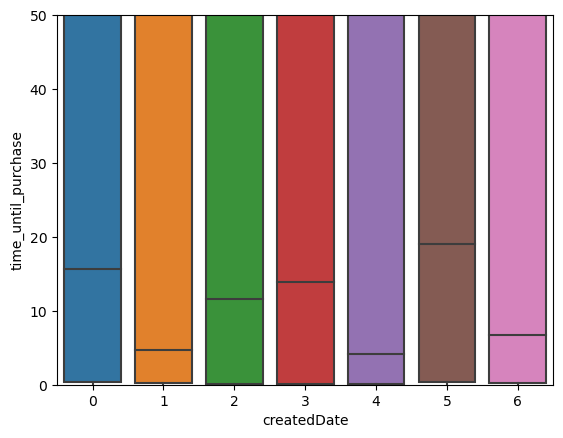

In [420]:
# date of signing up and time until purchase

dayofmonth = joined_df.createdDate.apply(lambda x: x.day)
month = joined_df.createdDate.apply(lambda x: x.month)
# time_until_purchase = joined_df.time_until_purchase
grand_total = joined_df.grand_total
time_until_purchase = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)

slice = ~ (joined_df.time_until_purchase.astype('int') == 0)
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
time_until_purchase = (joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)).loc[slice]

sns.boxplot(x=dayofweek, y=time_until_purchase)
plt.ylim((0, 50) )

<AxesSubplot:xlabel='createdDate', ylabel='time_until_purchase'>

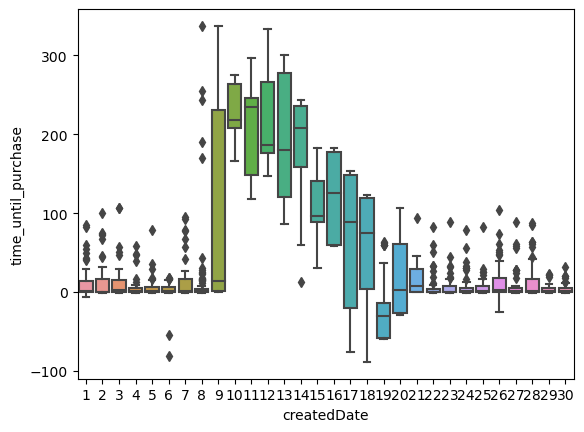

In [468]:
# date of signing up and time until purchase
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
dayofmonth = joined_df.createdDate.apply(lambda x: x.day)
month = joined_df.createdDate.apply(lambda x: x.month)
# time_until_purchase = joined_df.time_until_purchase
grand_total = joined_df.grand_total.loc[slice]
time_until_purchase = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)
dayofmonth_hijri = joined_df.createdDate.apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)

slice = ~ (joined_df.time_until_purchase.astype('int') == 0)
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
time_until_purchase = (joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)).loc[slice]
grand_total = joined_df.grand_total.loc[slice]
dayofmonth_hijri = dayofmonth_hijri.loc[slice]
month = joined_df.createdDate.apply(lambda x: x.month)

sns.boxplot(x=dayofmonth_hijri, y=time_until_purchase)

In [434]:
# create a transactions df that has the registration date
transactions.merge(customers, 'left', left_on='buyer_phone', right_on='customer_phone')

,ID_x,date,status,buyer_phone,buyer_city,grand_total,month,day,ID_y,customer_phone,createdDate,lastLoginDate
0,1,2025-08-19 00:00:00.000,refunded,536047743,Riyadh,10849.950,8,19,3497,536047743,17/08/2025T22:39:34.834Z,18/08/2025T13:09:42.971Z
1,3,2025-08-19 00:00:00.000,refunded,555755225,Riyadh,6630.525,8,19,3051,555755225,16/08/2025T16:17:01.168Z,19/08/2025T16:14:37.322Z
2,5,2025-08-19 00:00:00.000,Transferred,558411024,Abha,12671.100,8,19,3645,558411024,18/08/2025T14:10:21.515Z,19/08/2025T19:04:20.269Z
3,7,2025-08-19 00:00:00.000,Transferred,544920156,Skakah,14136.000,8,19,2039,544920156,13/08/2025T20:06:50.206Z,19/08/2025T22:09:44.761Z
4,10,2025-08-21 00:00:00.000,Transferred,569281258,Makkah,6498.000,8,21,5093,569281258,21/08/2025T07:47:07.708Z,26/08/2025T10:49:37.445Z
...,...,...,...,...,...,...,...,...,...,...,...,...
2486,3601,2025-12-13 12:15:59.904,refunded,534246162,Riyadh,7310.250,12,13,77053,534246162,09/12/2025T08:55:37.475Z,09/12/2025T08:55:37.479Z
2487,3602,2025-12-13 12:15:59.904,Transferred,533120003,Khobar,16216.500,12,13,80896,533120003,12/12/2025T22:02:00.378Z,13/12/2025T16:06:08.964Z
2488,3604,2025-12-13 12:15:59.904,refunded,591256788,Riyadh,1345.200,12,13,80100,591256788,11/12/2025T20:09:06.459Z,13/12/2025T00:16:19.259Z
2489,3605,2025-12-13 12:15:59.904,Transferred,597160899,Skakah,5172.750,12,13,37542,597160899,19/10/2025T06:07:42.984Z,09/11/2025T16:02:30.340Z


In [449]:
# create a transactions df that has makes_second_purchase rate
purchase_customer = purchase_df.merge(customers, 'right', left_on='buyer_phone', right_on='customer_phone')
# purchase_customer.loc[purchase_customer.makes_second_purchase == True]
# purchase_customer['registration_month'] = purchase_customer.createdDate.tz_localize(None).month
purchase_customer['registration_year'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.year)
purchase_customer['registration_month'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.month)
purchase_customer['registration_day'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.day)
purchase_customer['registration_dayofweek'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: x.dayofweek)

purchase_customer['registration_year_hijri'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().year)
purchase_customer['registration_month_hijri'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().month)
purchase_customer['registration_day_hijri'] = pd.to_datetime(purchase_customer.createdDate, infer_datetime_format=True).dt.tz_localize(None).apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)

In [450]:
purchase_customer.head()

,ID_x,date,status,buyer_phone,buyer_city,grand_total,purchase_1,purchase_2,purchase_3,makes_second_purchase,...,customer_phone,createdDate,lastLoginDate,registration_year,registration_month,registration_day,registration_dayofweek,registration_year_hijri,registration_month_hijri,registration_day_hijri
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z,2025,1,8,2,1446,7,8
1,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z,2025,1,8,2,1446,7,8
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z,2025,1,8,2,1446,7,8
3,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z,2025,1,8,2,1446,7,8
4,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z,2025,1,8,2,1446,7,8


In [462]:
# conversion rate of different months of registration date
months_conversion_hijri = purchase_customer.groupby('registration_month_hijri').apply(lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))
months_conversion_hijri

registration_month_hijri
1     7.227241
2     1.212659
3     3.376103
4     5.017597
5     4.285993
6     2.781878
7     4.892704
8     3.221884
9     3.286573
10    1.467300
11    3.135818
12    3.317282
dtype: float64

In [470]:
purchase_customer.registration_year.unique()

array([2025])

<AxesSubplot:xlabel='createdDate', ylabel='time_until_purchase'>

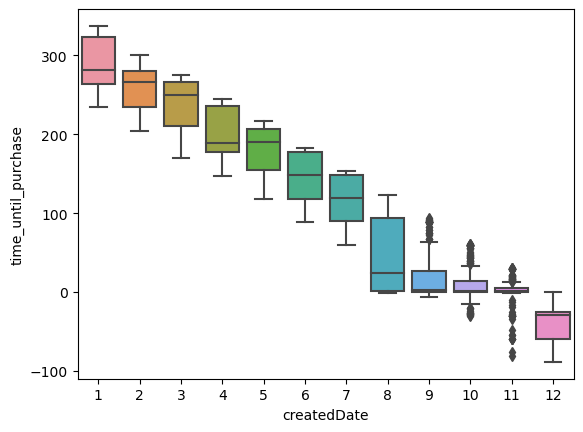

In [469]:
# date of signing up and time until purchase
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
dayofmonth = joined_df.createdDate.apply(lambda x: x.day)
month = joined_df.createdDate.apply(lambda x: x.month)
# time_until_purchase = joined_df.time_until_purchase
grand_total = joined_df.grand_total.loc[slice]
time_until_purchase = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)
dayofmonth_hijri = joined_df.createdDate.apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri())

slice = ~ (joined_df.time_until_purchase.astype('int') == 0)
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
time_until_purchase = (joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)).loc[slice]
grand_total = joined_df.grand_total.loc[slice]
dayofmonth_hijri = dayofmonth_hijri.loc[slice]
month = joined_df.createdDate.apply(lambda x: x.month).loc[slice]

sns.boxplot(x=month, y=time_until_purchase)
# plt.ylim((0, 50) )

In [472]:
month.value_counts().sum()

1857

<AxesSubplot:>

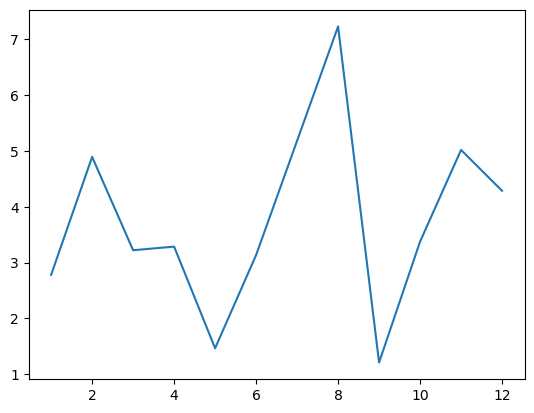

In [461]:
# date of signing up and time until purchase
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
dayofmonth = joined_df.createdDate.apply(lambda x: x.day)
month = joined_df.createdDate.apply(lambda x: x.month)
# time_until_purchase = joined_df.time_until_purchase
grand_total = joined_df.grand_total.loc[slice]
time_until_purchase = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)
dayofmonth_hijri = joined_df.createdDate.apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)

slice = ~ (joined_df.time_until_purchase.astype('int') == 0)
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
time_until_purchase = (joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)).loc[slice]
grand_total = joined_df.grand_total.loc[slice]
dayofmonth_hijri = dayofmonth_hijri.loc[slice]

sns.lineplot(x=pd.Series(purchase_customer.registration_month_hijri.unique()).sort_values(), y=months_conversion_hijri)

### actionable insight: advertise heavily before the school year starts (August).

Text(0, 0.5, 'Conversion rate: % of new users who bought a device')

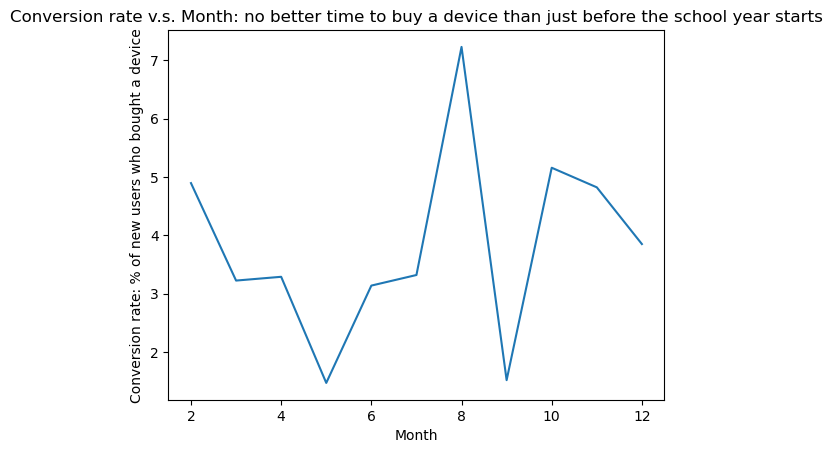

In [466]:
months_conversion = purchase_customer.groupby('registration_month').apply(lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))
sns.lineplot(x=pd.Series(purchase_customer.registration_month.unique()).sort_values(), y=months_conversion)
plt.title("Conversion rate v.s. Month: no better time to buy a device than just before the school year starts")

plt.xlabel("Month")
plt.ylabel("Conversion rate: % of new users who bought a device")



In [473]:
dayofweek_conversion = purchase_customer.query("registration_month > 7").groupby('registration_dayofweek').apply(
    lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))
dayofweek_conversion

registration_dayofweek
0    3.522868
1    1.787494
2    3.404731
3    4.479348
4    2.916805
5    4.314760
6    4.103039
dtype: float64

In [464]:
# conversion rate of different months of registration date
months_conversion_hijri = purchase_customer.groupby('registration_month_hijri').apply(lambda x: (float(x.purchase_1.count()) / float(x.customer_phone.nunique()) * 100))
months_conversion_hijri

sns.lineplot(x=pd.Series(purchase_customer.registration_dayofweek.unique()).sort_values(), y=months_conversion_hijri)

,registration_month,registration_month_hijri
0,1,7
1,1,7
2,1,7
3,1,7
4,1,7
5,1,7
6,1,7
7,1,7
8,1,7
9,1,7


In [438]:
customers.shape

(82851, 4)

<AxesSubplot:xlabel='createdDate', ylabel='time_until_purchase'>

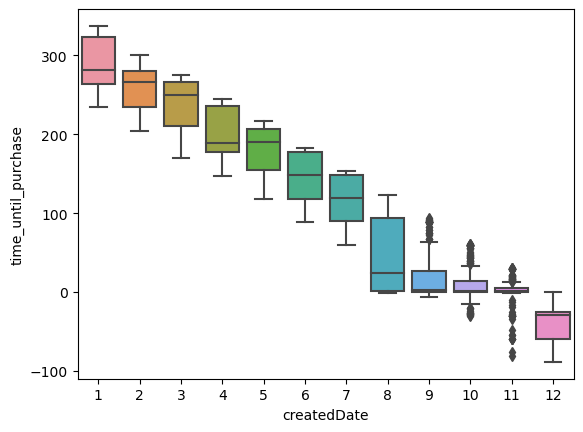

In [432]:
# date of signing up and time until purchase
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
dayofmonth = joined_df.createdDate.apply(lambda x: x.day)
month = joined_df.createdDate.apply(lambda x: x.month)
# time_until_purchase = joined_df.time_until_purchase
grand_total = joined_df.grand_total.loc[slice]
time_until_purchase = joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)
dayofmonth_hijri = joined_df.createdDate.apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)

slice = ~ (joined_df.time_until_purchase.astype('int') == 0)
dayofweek = joined_df.createdDate.apply(lambda x: x.dayofweek).loc[slice]
time_until_purchase = (joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)).loc[slice]
grand_total = joined_df.grand_total.loc[slice]
dayofmonth_hijri = dayofmonth_hijri.loc[slice]
month = month.loc[slice]

sns.boxplot(x=month, y=time_until_purchase)

In [430]:
dayofmonth_hijri.value_counts()

1446-10-12    112
1447-02-18     47
1446-10-14     47
1447-04-24     46
1446-11-14     38
             ... 
1447-03-23      2
1447-04-19      2
1447-06-17      1
1446-12-12      1
1447-03-16      1
Name: createdDate, Length: 132, dtype: int64

In [423]:
dayofmonth.value_counts()

10    298
12    274
11    124
9     107
16     76
25     69
18     66
30     66
24     64
19     58
17     56
23     55
27     55
26     54
29     53
21     52
22     51
31     50
20     50
14     46
15     45
28     37
13     30
8      21
Name: createdDate, dtype: int64

In [427]:
from hijri_converter import Hijri, Gregorian
created_date_hijri = joined_df.createdDate.apply(lambda x: Gregorian(x.year, x.month, x.day).to_hijri().day)
dayofmonth_hijri = created_date_hijri


In [387]:
# broken ********************************

# if column == 'date':
#     column = ['month', 'day']

# if func1 == 'sum':
#     city_month = transactions.groupby(groupby).sum()[column]
# elif func1 == 'mean':
#     city_month = transactions.groupby(groupby).mean()[column]
# else:
#     raise Exception

city_month = transactions.groupby(groupby).mean()[column]
city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x[column].transform(func2))

# months_unique = city_month_pctgs.index.unique(level='month')

# index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])
# props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)
# for month in months_unique:
#     count = 0
#     for i in range(N_FIRST):
#         proportion_city = city_month_pctgs.loc[month].sort_values(by=column, ascending=False).iloc[i]
        
#         props.loc[(month, i), 'buyer_city'] = proportion_city.name
#         props.loc[(month, i), 'proportion'] = proportion_city.iloc[0]
props = city_month_pctgs
props = props.reset_index(level=0)

    

# best_cities['proportion'] = best_cities.proportion.astype('float')
# best_cities = best_cities.reset_index(level=0)
# type(bobo)
best_cities

ID             1.812579e+03
buyer_phone    5.532084e+08
grand_total    6.888685e+03
month          1.045959e+01
day            1.514440e+01
dtype: float64

In [392]:
joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)

0        5.201926
1       -0.442245
2        4.532579
3        6.532579
4        7.324686
          ...    
629    274.532272
630    122.660428
631     17.319116
632    279.216067
633    153.847880
Name: time_until_purchase, Length: 634, dtype: float64

In [390]:
get_month_growth(column = 'date', func1 = 'mean', func2 = pd.Series.pct_change, groupby = ['buyer_city', 'month'])

,buyer_city,month,day
0,Abha,NaN,NaN
1,Al Baha,NaN,NaN
2,Al Qassim,NaN,NaN
3,Dammam,NaN,NaN
4,Jeddah,NaN,NaN
5,Khobar,NaN,NaN
6,Makkah,NaN,NaN
7,Rafha,NaN,NaN
8,Ras Tannurah,NaN,NaN
9,Riyadh,NaN,NaN


In [388]:
# new ********************************
def get_month_growth(column = 'grand_total', func1 = 'sum', func2 = pd.Series.pct_change, groupby = ['buyer_city', 'month']):
    
    if column == 'date':
        column = ['month', 'day']
    
    if func1 == 'sum':
        city_month = transactions.groupby(groupby).sum()[column]
    elif func1 == 'mean':
        city_month = transactions.groupby(groupby).mean()[column]
    else:
        raise Exception
    
    city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x[column].transform(func2))



    
    # months_unique = city_month_pctgs.index.unique(level='month')
    
    # index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])

    # props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)

    # for month in months_unique:
    #     count = 0
    #     for i in range(N_FIRST):
    #         proportion_city = city_month_pctgs.loc[month].sort_values(by=column, ascending=False).iloc[i]
            
    #         props.loc[(month, i), 'buyer_city'] = proportion_city.name
    #         props.loc[(month, i), 'proportion'] = proportion_city.iloc[0]
    props = city_month_pctgs
    props = props.reset_index(level=0)
    return props    
    
best_cities = get_month_growth()
# best_cities['proportion'] = best_cities.proportion.astype('float')
# best_cities = best_cities.reset_index(level=0)
# type(bobo)
best_cities

KeyError: 'grand_total'

In [375]:
# old ********************************
def get_month_growth(column = 'grand_total', sum_or_count = 'sum', groupby = ['buyer_city', 'month']):
    
    city_month = transactions.groupby(groupby).sum()[[column]]

    
    city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x[column].pct_change())



    
    # months_unique = city_month_pctgs.index.unique(level='month')
    
    # index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])

    # props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)

    # for month in months_unique:
    #     count = 0
    #     for i in range(N_FIRST):
    #         proportion_city = city_month_pctgs.loc[month].sort_values(by=column, ascending=False).iloc[i]
            
    #         props.loc[(month, i), 'buyer_city'] = proportion_city.name
    #         props.loc[(month, i), 'proportion'] = proportion_city.iloc[0]
    props = city_month_pctgs
    props = props.reset_index(level=0)
    return props    
    
best_cities = get_month_growth()
# best_cities['proportion'] = best_cities.proportion.astype('float')
# best_cities = best_cities.reset_index(level=0)
# type(bobo)
best_cities

buyer_city  grand_total
buyer_city month                        
Abha       8           Abha          NaN
           9           Abha     0.815177
           10          Abha     1.404565
           11          Abha     0.207063
           12          Abha    -0.372453
...                     ...          ...
Taif       8           Taif          NaN
           9           Taif     3.582083
           10          Taif     1.243043
           11          Taif    -0.142864
           12          Taif    -0.218980

[65 rows x 2 columns]

In [361]:
list(transactions.groupby('buyer_city').sum()['grand_total'].sort_values(ascending=False)[0:N_FIRST].index)

Index(['Riyadh', 'Ras Tannurah', 'Al Qassim'], dtype='object', name='buyer_city')

In [364]:
best_cities.buyer_city.apply(lambda x: x in important_cities) 

buyer_city  month
Abha        8        False
            9        False
            10       False
            11       False
            12       False
                     ...  
Taif        8        False
            9        False
            10       False
            11       False
            12       False
Name: buyer_city, Length: 65, dtype: bool

In [376]:
# calculate proportion of sales made outside the top 3 cities
# other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())
best_cities = get_month_growth(column = 'grand_total', func1 = pd.Series.sum, func2 = pd.Series.pct_change, groupby = ['buyer_city', 'month'])
month = best_cities.index.get_level_values('month')
buyer_city = best_cities.index.get_level_values('buyer_city')
important_cities = list(transactions.groupby('buyer_city').sum()['grand_total'].sort_values(ascending=False)[0:N_FIRST].index)
best_cities = best_cities.loc[best_cities.buyer_city.apply(lambda x: x in important_cities)]
month = best_cities.index.get_level_values('month')
buyer_city = best_cities.index.get_level_values('buyer_city')
print(best_cities)
# make plot
sns.lineplot(x=month, y=best_cities.grand_total*100, hue=best_cities.buyer_city)
# plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Growth in sales total value")

TypeError: get_month_growth() got an unexpected keyword argument 'func1'

In [344]:
def get_month_precentages(column = 'grand_total', sum_or_count = 'sum', groupby = ['month', 'buyer_city']):
    
    #new
    city_month = transactions.groupby(groupby).sum()[[column]]

    city_month_pctgs = city_month.groupby(level=0).apply(lambda x: x / x.sum())

    # city_month_pctgs.groupby('month').sort_values()
    city_month_pctgs
    
    
    # old

    city_month = transactions.groupby(['month', 'buyer_city']).sum()['grand_total']
    months_unique = city_month_pctgs.index.unique(level='month')
    index = pd.MultiIndex.from_product([list(months_unique), list(range(3))])

    props = pd.DataFrame(columns=['buyer_city', 'proportion'], index=index)

    for month in months_unique:
        count = 0
        for i in range(N_FIRST):
            proportion_city = city_month_pctgs.loc[month].sort_values(by=column, ascending=False).iloc[i]
            
            props.loc[(month, i), 'buyer_city'] = proportion_city.name
            props.loc[(month, i), 'proportion'] = proportion_city.iloc[0]

    return props    
    
best_cities = get_month_figures()
best_cities['proportion'] = best_cities.proportion.astype('float')
best_cities

buyer_city  proportion
8  0        Riyadh    0.290129
   1  Ras Tannurah    0.104120
   2        Skakah    0.091770
9  0        Riyadh    0.318622
   1  Ras Tannurah    0.108217
   2     Al Qassim    0.105666
10 0        Riyadh    0.279204
   1     Al Qassim    0.108344
   2  Ras Tannurah    0.095646
11 0        Riyadh    0.311680
   1  Ras Tannurah    0.102326
   2     Al Qassim    0.085700
12 0        Riyadh    0.265461
   1  Ras Tannurah    0.104183
   2     Al Qassim    0.080645

Text(0.5, 1.0, 'Proportion of sales in different cities')

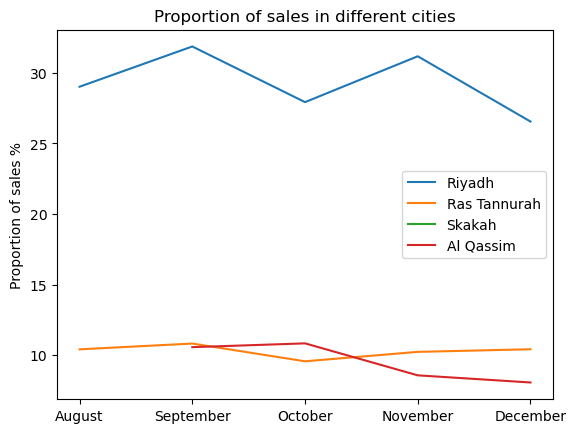

In [343]:
# calculate proportion of sales made outside the top 3 cities
# other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())
month = best_cities.index.get_level_values(0)

# make plot
sns.lineplot(x=month, y=best_cities.proportion*100, hue=best_cities.buyer_city)
# plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of sales in different cities")

In [340]:
# proportion of sales in riyals (not absolute number)
proportions_riyals = get_proportions(transactions, months, absolute=False)
df_proportion_riyals = pd.DataFrame({"proportion":pd.concat(proportions_riyals), "month":list(np.repeat(months, N_BEST))})
df_proportion_riyals['buyer_city'] = df_proportion_riyals.index
df_proportion_riyals.reset_index(drop=True, inplace=True)
df_proportion_riyals

,proportion,month,buyer_city
0,0.104120,8,Ras Tannurah
1,0.290129,8,Riyadh
2,0.091770,8,Skakah
3,0.105666,9,Al Qassim
4,0.108217,9,Ras Tannurah
5,0.318622,9,Riyadh
6,0.108344,10,Al Qassim
7,0.095646,10,Ras Tannurah
8,0.279204,10,Riyadh
9,0.085700,11,Al Qassim


Text(0.5, 1.0, 'Proportion of sales in different cities')

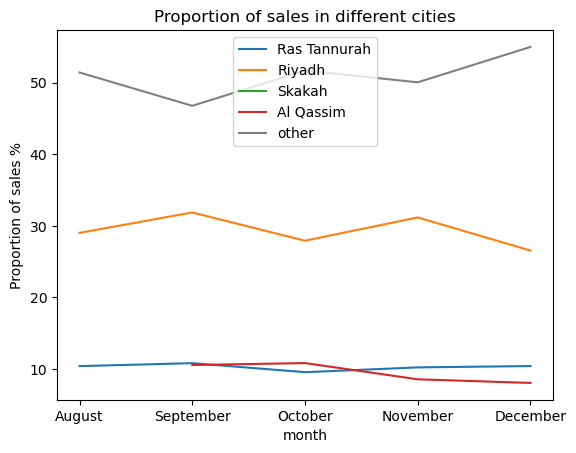

In [341]:
# calculate proportion of sales made outside the top 3 cities
other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())

# make plot
sns.lineplot(x=df_proportion_riyals.month, y=df_proportion_riyals.proportion*100, hue=df_proportion_riyals.buyer_city)
plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of sales in different cities")

AttributeError: 'Line2D' object has no property 'heu'

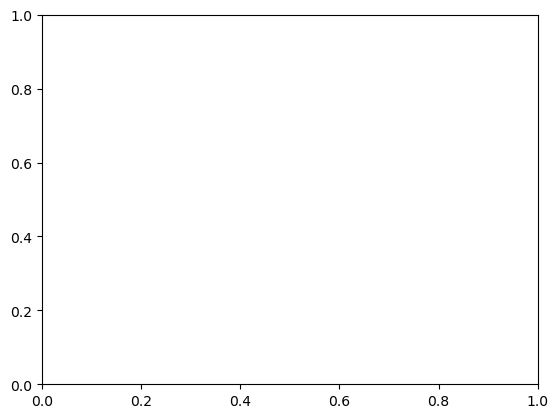

In [307]:
# plot best selling cities 
index = best_cities.index
months = list(pd.MultiIndex.get_level_values(index, 0).unique())
index = pd.MultiIndex.reorder_levels(index, [1,0])

for i in range(N_FIRST):
    
    # index = pd.MultiIndex.reorder_levels(index, [1,0])
    slice = pd.MultiIndex.get_loc(index, i)
    data = best_cities.iloc[slice]
    # sns.lineplot(best_cities.iloc[slice], x=months, y='proportions', heu='buyer_city')
    # sns.lineplot(best_cities, x=months, )
    plt.plot(months, data.proportion, group=data.buyer_city)

In [281]:
reordered_index = pd.MultiIndex.reorder_levels(index, [1,0])

In [283]:
slice = pd.MultiIndex.get_loc(reordered_index, 0)
slice

array([ True, False, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False])

In [284]:
best_cities.iloc[slice]

,,buyer_city,proportion
8,0,Riyadh,0.290129
9,0,Riyadh,0.318622
10,0,Riyadh,0.279204
11,0,Riyadh,0.31168
12,0,Riyadh,0.265461


In [287]:
pd.MultiIndex.get_level_values(index, 0).unique()

Int64Index([8, 9, 10, 11, 12], dtype='int64')

In [311]:
# define magic numbers
N_BEST = 3

In [31]:
# create months list
print(transactions.date.min())
print(transactions.date.max())
# create attributes for month and day of transactions (year is always 2025)
transactions['month'] = transactions.date.apply(lambda d: d.month)
transactions['day'] = transactions.date.apply(lambda d: d.day)

2025-08-19 00:00:00
2025-12-13 12:15:59.904000


In [32]:
# create a list containing the months in the data set
months = pd.Series(transactions.month.loc[transactions.month.unique()].index)
months 

0     8
1     9
2    10
3    11
4    12
dtype: int64

In [312]:
def get_proportions(df, months, top_n = N_BEST, absolute = True):
    proportions = []
    # months_repeated = []
    # assert months
    if absolute:
        for month in months:
            proportions_this_month = (df.query(f"month == {month}").buyer_city.value_counts() / df.query(f"month == {month}").count()[0]).iloc[0:top_n]
            proportions.append(proportions_this_month.sort_index())
            # months_repeated.append(month)
    else:
        for month in months:
            total_sales_cities = df.query(f"month == {month}").groupby("buyer_city")['grand_total'].sum().sort_values(ascending=False)
            proportions_this_month = (total_sales_cities / df.query(f"month == {month}").grand_total.sum()).iloc[0:top_n]
            proportions.append(proportions_this_month.sort_index())

    return proportions

In [313]:
proportions = get_proportions(transactions, months)
# proportions.head(1)

In [314]:
df_proportion_sales = pd.DataFrame({"proportion":pd.concat(proportions), "month":list(np.repeat(months, N_BEST))})
df_proportion_sales['buyer_city'] = df_proportion_sales.index
df_proportion_sales.reset_index(drop=True, inplace=True)
df_proportion_sales

,proportion,month,buyer_city
0,0.088000,8,Al Qassim
1,0.128000,8,Ras Tannurah
2,0.296000,8,Riyadh
3,0.119734,9,Al Qassim
4,0.104213,9,Ras Tannurah
5,0.294900,9,Riyadh
6,0.103753,10,Al Qassim
7,0.089404,10,Ras Tannurah
8,0.273731,10,Riyadh
9,0.095506,11,Al Qassim


In [315]:
# proportion of sales in riyals (not absolute number)
proportions_riyals = get_proportions(transactions, months, absolute=False)
df_proportion_riyals = pd.DataFrame({"proportion":pd.concat(proportions_riyals), "month":list(np.repeat(months, N_BEST))})
df_proportion_riyals['buyer_city'] = df_proportion_riyals.index
df_proportion_riyals.reset_index(drop=True, inplace=True)
df_proportion_riyals

,proportion,month,buyer_city
0,0.104120,8,Ras Tannurah
1,0.290129,8,Riyadh
2,0.091770,8,Skakah
3,0.105666,9,Al Qassim
4,0.108217,9,Ras Tannurah
5,0.318622,9,Riyadh
6,0.108344,10,Al Qassim
7,0.095646,10,Ras Tannurah
8,0.279204,10,Riyadh
9,0.085700,11,Al Qassim


Text(0.5, 1.0, 'Proportion of sales in different cities')

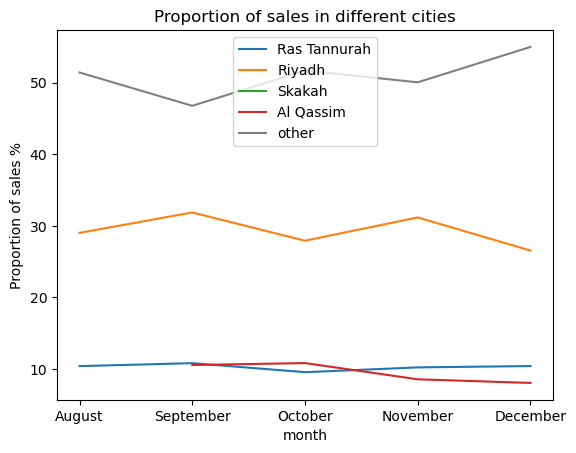

In [316]:
# calculate proportion of sales made outside the top 3 cities
other_cities = (1 - df_proportion_riyals.groupby('month')['proportion'].sum())

# make plot
sns.lineplot(x=df_proportion_riyals.month, y=df_proportion_riyals.proportion*100, hue=df_proportion_riyals.buyer_city)
plt.plot(df_proportion_riyals.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of sales in different cities")

In [317]:
# create 3 series, one for each city
cities = df_proportion_sales.buyer_city.unique()
prop = pd.DataFrame(columns=cities, dtype='float')

for city in cities:
    prop_city = df_proportion_sales.loc[df_proportion_sales.buyer_city == city]['proportion']
    # print(prop_city)
    prop[city] = prop_city
    # print(prop_city)
prop

,Al Qassim,Ras Tannurah,Riyadh
0,0.088000,NaN,NaN
3,0.119734,NaN,NaN
6,0.103753,NaN,NaN
9,0.095506,NaN,NaN
12,0.092308,NaN,NaN


Text(0.5, 1.0, 'Proportion of customers in different cities')

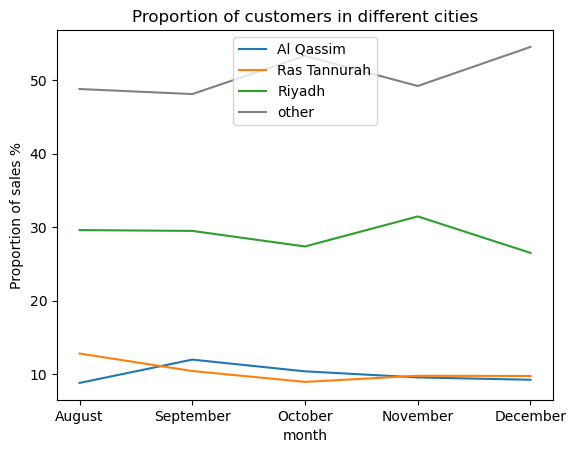

In [318]:
# calculate proportion of sales made outside the top 3 cities
other_cities = (1 - df_proportion_sales.groupby('month')['proportion'].sum())

# make plot
sns.lineplot(x=df_proportion_sales.month, y=df_proportion_sales.proportion*100, hue=df_proportion_sales.buyer_city)
plt.plot(df_proportion_sales.month.unique(), other_cities*100, label="other", color='grey')
plt.xticks([8,9,10,11,12], labels=['August', 'September', 'October', 'November', 'December'])
plt.legend()
plt.ylabel("Proportion of sales %")
plt.title("Proportion of customers in different cities")

Result 4: the average time between registration date and purchase date

In [396]:
first_purchase_df = transactions.loc[~ transactions.duplicated(subset="buyer_phone", keep='first')]
# first_purchase_df = first_purchase_df.reset_index() #********************************
# first_purchase_df.drop(columns=["index", "ID"])
first_purchase_df.shape

(2138, 8)

In [397]:
first_purchase_df.head()

,ID,date,status,buyer_phone,buyer_city,grand_total,month,day
0,1,2025-08-19,refunded,536047743,Riyadh,10849.950,8,19
1,3,2025-08-19,refunded,555755225,Riyadh,6630.525,8,19
2,4,2025-08-19,Transferred,551540834,Abha,8122.500,8,19
3,5,2025-08-19,Transferred,558411024,Abha,12671.100,8,19
4,6,2025-08-19,Transferred,509292218,Abha,7233.300,8,19


In [321]:
customers.head()

,ID,customer_phone,createdDate,lastLoginDate
0,1,556736718,01/08/2025T08:28:25.471Z,01/08/2025T08:28:34.830Z
1,2,564760303,01/08/2025T08:31:15.696Z,10/09/2025T07:44:25.074Z
2,3,530903122,01/08/2025T08:58:21.856Z,01/08/2025T08:59:35.462Z
3,4,506040253,01/08/2025T09:08:19.853Z,01/08/2025T09:09:09.052Z
4,5,531402212,01/08/2025T09:12:53.093Z,01/08/2025T09:12:59.441Z


In [398]:
first_purchase_df.shape

(2138, 8)

In [399]:
joined_df = first_purchase_df.merge(customers, left_on="buyer_phone", right_on="customer_phone", how="inner", suffixes=['_purchased', '_customer'])
joined_df.head()

,ID_purchased,date,status,buyer_phone,buyer_city,grand_total,month,day,ID_customer,customer_phone,createdDate,lastLoginDate
0,1,2025-08-19,refunded,536047743,Riyadh,10849.950,8,19,3497,536047743,17/08/2025T22:39:34.834Z,18/08/2025T13:09:42.971Z
1,3,2025-08-19,refunded,555755225,Riyadh,6630.525,8,19,3051,555755225,16/08/2025T16:17:01.168Z,19/08/2025T16:14:37.322Z
2,5,2025-08-19,Transferred,558411024,Abha,12671.100,8,19,3645,558411024,18/08/2025T14:10:21.515Z,19/08/2025T19:04:20.269Z
3,7,2025-08-19,Transferred,544920156,Skakah,14136.000,8,19,2039,544920156,13/08/2025T20:06:50.206Z,19/08/2025T22:09:44.761Z
4,10,2025-08-21,Transferred,569281258,Makkah,6498.000,8,21,5093,569281258,21/08/2025T07:47:07.708Z,26/08/2025T10:49:37.445Z


In [400]:
joined_df.shape[0] / first_purchase_df.shape[0]

0.8685687558465855

- Over a fifth of the customers who made purchases (and had their phone number recorded in transactions dataframe), could not be found on the customers dataframe
- (there phone numbers might have changed since registration and ordering, or some other explanation)

In [324]:
joined_df.iloc[0][["createdDate", "lastLoginDate"]]

createdDate      16/08/2025T19:09:13.583Z
lastLoginDate    29/08/2025T08:11:12.617Z
Name: 0, dtype: object

In [401]:
joined_df['createdDate'] = pd.to_datetime(joined_df.createdDate, infer_datetime_format=True).dt.tz_localize(None)
joined_df['lastLoginDate'] = pd.to_datetime(joined_df.lastLoginDate, infer_datetime_format=True).dt.tz_localize(None)
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 0 to 1856
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID_purchased    1857 non-null   int64         
 1   date            1857 non-null   datetime64[ns]
 2   status          1857 non-null   object        
 3   buyer_phone     1857 non-null   int64         
 4   buyer_city      1857 non-null   object        
 5   grand_total     1857 non-null   float64       
 6   month           1857 non-null   int64         
 7   day             1857 non-null   int64         
 8   ID_customer     1857 non-null   int64         
 9   customer_phone  1857 non-null   int64         
 10  createdDate     1857 non-null   datetime64[ns]
 11  lastLoginDate   1857 non-null   datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(6), object(2)
memory usage: 188.6+ KB


In [402]:
time_until_purchase = joined_df.date - joined_df.createdDate 
joined_df['time_until_purchase'] = time_until_purchase
joined_df['time_until_purchase'].std()

Timedelta('93 days 11:31:46.591708721')

In [403]:
joined_df.time_until_purchase

0        1 days 01:20:25.166000
1        2 days 07:42:58.832000
2        0 days 09:49:38.485000
3        5 days 03:53:09.794000
4      -1 days +16:12:52.292000
                 ...           
1852    92 days 03:20:22.429000
1853     0 days 14:13:59.526000
1854    30 days 16:06:53.445000
1855    55 days 06:08:16.920000
1856   123 days 10:19:20.881000
Name: time_until_purchase, Length: 1857, dtype: timedelta64[ns]

In [404]:
joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)

0         1.055847
1         2.321514
2         0.409473
3         5.161919
4        -0.324395
           ...    
1852     92.139148
1853      0.593050
1854     30.671452
1855     55.255751
1856    123.430103
Name: time_until_purchase, Length: 1857, dtype: float64

Text(0.5, 1.0, 'Time between registration and purchase')

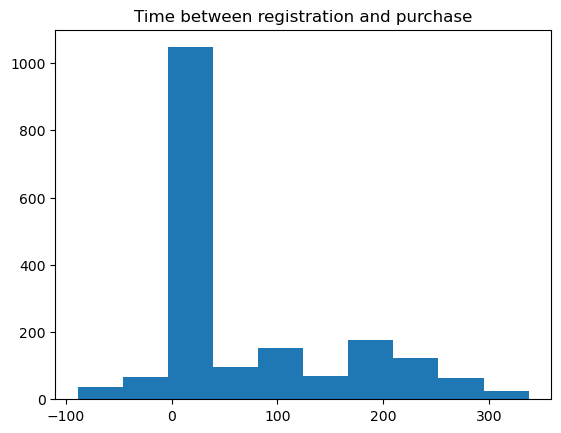

In [406]:
plt.hist(joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24), bins=10)
plt.title("Time between registration and purchase")

Some values are negative, which raises concerns about
- the quality of the data
- the consistency with which the data is inputed


In [330]:
((joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)) < 0).sum()

25

In [331]:
joined_df.time_until_purchase.loc[((joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24)) < 0)].sort_values()

280   -59 days +10:18:57.237000
283   -58 days +02:53:56.931000
284   -57 days +12:10:07.866000
306   -56 days +04:48:25.589000
317   -54 days +09:26:05.592000
433   -29 days +21:09:19.923000
444   -27 days +23:03:42.140000
285   -26 days +05:32:48.767000
505   -22 days +10:06:02.087000
533   -18 days +03:31:21.853000
223   -13 days +09:00:16.397000
553   -12 days +07:26:14.745000
382   -10 days +20:25:56.254000
400    -7 days +21:51:32.643000
554    -6 days +13:46:14.841000
194    -1 days +03:35:31.166000
121    -1 days +05:02:16.592000
244    -1 days +05:51:34.955000
327    -1 days +07:10:07.241000
309    -1 days +12:38:09.770000
196    -1 days +13:06:41.952000
195    -1 days +13:06:41.952000
1      -1 days +13:23:10.054000
7      -1 days +15:10:46.131000
208    -1 days +22:41:12.641000
Name: time_until_purchase, dtype: timedelta64[ns]

Result 5: Give us any actionable insight from the date given, the data point should be
where the insight is coming from should be different than the previous four
analyses mentioned above, examples can be:
a. Insight: 65% of the buyers are males between 18-24
Action: We should target universities students intensively
b. Insight: 80% of the transactions are happening on the weekdays
Action: We should not do our regular advertising on the weekend and we
might use a new approach

In [332]:
purchase_df.groupby(["purchase_1", 'purchase_2'])['purchase_3'].value_counts(normalize=True)

purchase_1  purchase_2  purchase_3
False       False       True          0.678322
                        False         0.321678
            True        True          0.615894
                        False         0.384106
True        False       True          0.660517
                        False         0.339483
            True        False         0.532051
                        True          0.467949
Name: purchase_3, dtype: float64

Those who accept the first two purchases, are unusually hesitant to accept the third purchase (46% accept rate, compared with 64%+ accept rate for other kinds of customers).
Those who return an item, are likely to accept the second item the next item they purchase.

Target customers who have recently returned a purchase to make another purchase bacause: 1) we know that they are looking to buy a device, 2) we know that they are disproportionatly likely to accept the next purchase.

In [333]:
purchase_df.groupby(["purchase_1", 'purchase_2', 'purchase_3'])['ID'].count()

purchase_1  purchase_2  purchase_3
False       False       False          46
                        True           97
            True        False          58
                        True           93
True        False       False          92
                        True          179
            True        False          83
                        True           73
Name: ID, dtype: int64

In [334]:
purchase_df.groupby(["purchase_1"])['purchase_2'].value_counts(normalize=True)

purchase_1  purchase_2
False       True          0.515810
            False         0.484190
True        False         0.542348
            True          0.457652
Name: purchase_2, dtype: float64

In [335]:
purchase_df.purchase_3.value_counts(normalize=True)
# pd.DataFrame.drop_duplicates()

True     0.613037
False    0.386963
Name: purchase_3, dtype: float64

In [336]:
purchase_df.columns

Index(['ID', 'date', 'status', 'buyer_phone', 'buyer_city', 'grand_total',
       'purchase_1', 'purchase_2', 'purchase_3', 'makes_second_purchase',
       'purchase_1_status', 'purchase_2_status', 'purchase_3_status',
       'makes_third_purchase'],
      dtype='object')

In [337]:
# create attributes: time_diff_1&2, time_diff_2&3, grand_total_diff_1, grand_total_diff_2
diffrences_df = purchase_df[['buyer_phone', 'purchase_1', 'purchase_2', 'purchase_3']].copy(deep=True)
diffrences_df.drop_duplicates('buyer_phone', inplace=True)
diffrences_df[['date_diff_1', 'date_diff_2', 'grand_total_diff_1', 'grand_total_diff_2']] = None

for buyer_phone, group in purchase_df.loc[~purchase_df.purchase_2.isna()].groupby("buyer_phone"):
    if group.shape[0] < 2:
        print('error')
        break
    # check if there are only two purchases
    if group.shape[0] == 2:
        df_temp = group[0:2][['date', 'grand_total']]
        # date and grand total of first and second purchase
        date_1, grand_total_1 = df_temp.iloc[0]
        date_2, grand_total_2 = df_temp.iloc[1]
        
        date_diff = (date_2 - date_1).total_seconds()
        grand_total_diff = grand_total_2 - grand_total_1
        
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['buyer_phone'] = buyer_phone
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['date_diff_1'] = date_diff
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['grand_total_diff_1'] = grand_total_diff
        
        diffrences_df.loc[diffrences_df.buyer_phone == buyer_phone, ['date_diff_1', 'grand_total_diff_1']] = [date_diff, grand_total_diff]
    # there is more than two purchases
    else:
        # date and grand total of first three purchases
        df_temp = group[0:3][['date', 'grand_total']]
        date_1, grand_total_1 = df_temp.iloc[0]
        date_2, grand_total_2 = df_temp.iloc[1]
        date_3, grand_total_3 = df_temp.iloc[2]
        
        date_diff_1 = (date_2 - date_1).total_seconds()
        grand_total_diff_1 = grand_total_2 - grand_total_1
        date_diff_2 = (date_3 - date_2).total_seconds()
        grand_total_diff_2 = grand_total_3 - grand_total_2
        
        # # diffrences_df.query(f'buyer_phone == {buyer_phone}')['buyer_phone'] = buyer_phone
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['date_diff_1'] = date_diff_1
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['grand_total_diff_1'] = grand_total_diff_1
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['date_diff_2'] = date_diff_2
        # diffrences_df.query(f'buyer_phone == {buyer_phone}')['grand_total_diff_2'] = grand_total_diff_2
        print([date_diff_1, date_diff_2, grand_total_diff_1, grand_total_diff_2])
        
        diffrences_df.loc[diffrences_df.buyer_phone == buyer_phone, ['date_diff_1', 'date_diff_2', 
                                                                     'grand_total_diff_1', 'grand_total_diff_2']] = [date_diff_1, date_diff_2, grand_total_diff_1, grand_total_diff_2]

diffrences_df[~diffrences_df.purchase_2.isna()].head(10)

[0.0, 518400.0, 594.7950000000001, -330.03000000000003]
[4665600.0, 473400.288, 428.4689999999996, 912.5700000000002]
[21600.0, 3600.288, 301.41599999999994, 2706.4170000000004]
[0.0, 86400.0, 0.0, -71.82]
[1085520.096, 120599.712, 2778.75, -3961.5]
[259200.0, 5184000.0, -570.0, -285.0]
[2160000.0, 4055616.0, 2028.3450000000003, 1591.1549999999997]
[417599.712, 541200.096, 566.0100000000002, 2516.834999999999]
[22199.616, 773400.096, 12760.02, -12971.775]
[86400.0, 3348000.0, 602.7750000000015, -967.5750000000007]
[255599.712, 432959.904, -3381.525, 0.0]
[1123200.0, 7340399.712, -2983.722, 3419.202]
[86400.0, 0.0, -768.9300000000003, 0.0]
[345600.0, 2332800.0, -809.4000000000001, -530.0999999999999]
[345600.0, 3246912.0, 0.0, -4219.424999999999]
[219600.288, 389759.904, 5306.985, -7182.0]
[241127.712, 2603232.0, 237.1199999999999, -3931.575]
[172800.0, 0.0, 3682.4849999999988, -4829.894999999999]
[0.0, 86400.0, -7182.0, 5158.100999999999]
[1640579.616, 3760380.288, 7956.345, 5901.15300

,buyer_phone,purchase_1,purchase_2,purchase_3,date_diff_1,date_diff_2,grand_total_diff_1,grand_total_diff_2
10,508383480,False,True,None,0.0,None,-1073.025,None
17,508460413,False,True,None,514200.096,None,1197.0,None
19,508579577,True,True,None,200519.712,None,-270.75,None
28,508867125,True,False,None,387695.808,None,-937.023,None
30,508873010,True,False,True,0.0,518400.0,594.795,-330.03
34,508907180,False,True,True,4665600.0,473400.288,428.469,912.57
39,508946919,False,False,None,3339419.616,None,-781.185,None
45,509045741,False,False,None,0.0,None,-1205.55,None
48,509092578,True,False,None,10800.0,None,1895.25,None
50,509137613,True,False,True,21600.0,3600.288,301.416,2706.417


In [338]:
counter = 0
total_sales = 0
for buyer_phone, group in transactions.groupby("buyer_phone"):
    if group.shape[0] > 1:
        counter += 1
        total_sales += group.shape[0]

counter, total_sales

(360, 1179)

In [339]:
at_least_2_df = diffrences_df.loc[diffrences_df['date_diff_1'].apply(lambda x: not pd.isna(x) and x.total_seconds != 0)]

AttributeError: 'float' object has no attribute 'total_seconds'

In [ ]:
datetime.timedelta.total_seconds(diffrences_df.iloc[0, 4])

TypeError: descriptor 'total_seconds' for 'datetime.timedelta' objects doesn't apply to a 'NoneType' object

In [ ]:
datetime.timedelta.total_seconds(diffrences_df.loc[~diffrences_df.purchase_2.isna()].iloc[0, 4])

In [ ]:
diffrences_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2956
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   buyer_phone         2138 non-null   int64 
 1   purchase_1          2138 non-null   object
 2   purchase_2          360 non-null    object
 3   purchase_3          131 non-null    object
 4   date_diff_1         360 non-null    object
 5   date_diff_2         131 non-null    object
 6   grand_total_diff_1  360 non-null    object
 7   grand_total_diff_2  131 non-null    object
dtypes: int64(1), object(7)
memory usage: 150.3+ KB


Text(0.5, 1.0, 'Time between registration and purchase')

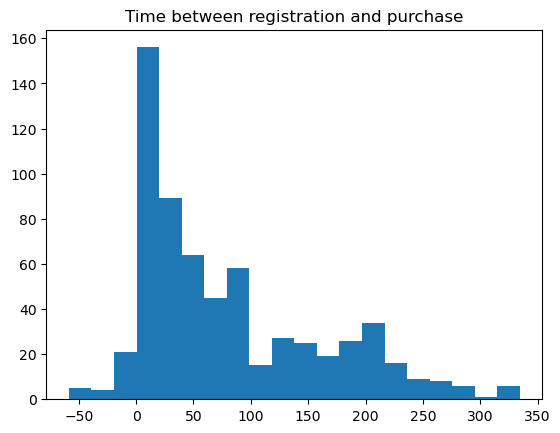

In [ ]:
plt.hist(joined_df.time_until_purchase.astype('int') / (1e9 * 60 * 60 * 24), bins=20)
plt.title("Time between registration and purchase")

Text(0.5, 1.0, 'Number of days between second and third purchase')

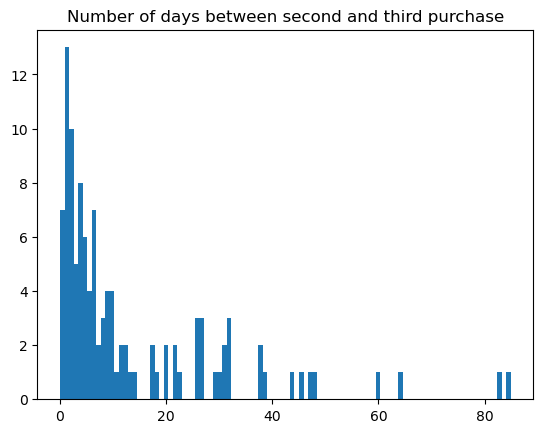

In [ ]:
plt.hist(diffrences_df.date_diff_2.loc[(~diffrences_df.purchase_3.isna() & diffrences_df.date_diff_2 > 0)] / (60 * 60 * 24), bins=100)

plt.title("Number of days between second and third purchase")

In [ ]:
diffrences_df.date_diff_2.count()

131

Can we make this plot more informative? 

In [ ]:
# Bin edges that will be used to "cut" the data into groups
bin_edges = [diffrences_df['date_diff_1'].min(), 
             diffrences_df['date_diff_1'].quantile(0.10),
             diffrences_df['date_diff_1'].quantile(0.20),
             diffrences_df['date_diff_1'].quantile(0.30),
             diffrences_df['date_diff_1'].quantile(0.40),
             diffrences_df['date_diff_1'].quantile(0.50),
             diffrences_df['date_diff_1'].quantile(0.60),
             diffrences_df['date_diff_1'].quantile(0.70),
             diffrences_df['date_diff_1'].quantile(0.80),
             diffrences_df['date_diff_1'].quantile(0.90),
             diffrences_df['date_diff_1'].max()] 
bin_edges

[-86400.0,
 0.0,
 86400.0,
 172800.0,
 345600.0,
 506057.76,
 691200.0,
 1045703.7791999999,
 1846907.6543999997,
 2939693.9904000005,
 8770559.904]

In [ ]:
# bin labels to use to name the attribute after cutting the data
bin_names = np.array([
             diffrences_df['date_diff_1'].quantile(0.10),
             diffrences_df['date_diff_1'].quantile(0.20),
             diffrences_df['date_diff_1'].quantile(0.30),
             diffrences_df['date_diff_1'].quantile(0.40),
             diffrences_df['date_diff_1'].quantile(0.50),
             diffrences_df['date_diff_1'].quantile(0.60),
             diffrences_df['date_diff_1'].quantile(0.70),
             diffrences_df['date_diff_1'].quantile(0.80),
             diffrences_df['date_diff_1'].quantile(0.90),
             diffrences_df['date_diff_1'].max()]) / (60 * 60 * 24)
bin_names = np.array(bin_names, dtype=int)
bin_names

array([  0,   1,   2,   4,   5,   8,  12,  21,  34, 101])

In [ ]:
at_least_2_df = diffrences_df.loc[~diffrences_df.purchase_2.isna()]
at_least_2_df['date_diff_1_levels'] = pd.cut(at_least_2_df['date_diff_1'], bin_edges, labels=bin_names)
at_least_2_df

,buyer_phone,purchase_1,purchase_2,purchase_3,date_diff_1,date_diff_2,grand_total_diff_1,grand_total_diff_2,date_diff_1_levels
10,508383480,False,True,None,0.0,None,-1073.025,None,0
17,508460413,False,True,None,514200.096,None,1197.0,None,8
19,508579577,True,True,None,200519.712,None,-270.75,None,4
28,508867125,True,False,None,387695.808,None,-937.023,None,5
30,508873010,True,False,True,0.0,518400.0,594.795,-330.03,0
...,...,...,...,...,...,...,...,...,...
2907,598009506,False,True,None,2154420.288,None,-883.5,None,34
2922,598891216,False,True,None,7773359.616,None,-1649.466,None,101
2933,599396690,False,False,None,1698300.0,None,-2964.0,None,21
2942,599630759,False,False,None,248832.0,None,285.0,None,4


In [ ]:
at_least_2_df.groupby('date_diff_1_levels')['grand_total_diff_1'].mean()

date_diff_1_levels
0     -550.411000
1       62.212909
2      375.930000
4      463.814561
5      265.369200
8     -222.379800
12     484.744031
21    -106.827500
34     368.813750
101     82.056250
Name: grand_total_diff_1, dtype: float64

In [ ]:
# get counts for each rating and color
status_counts = at_least_2_df.groupby(['date_diff_1_levels', 'purchase_1']).count()['buyer_phone']
status_counts

date_diff_1_levels  purchase_1
0                   False         23
                    True          22
1                   False         19
                    True          25
2                   False          8
                    True          11
4                   False         22
                    True          19
5                   False         16
                    True          14
8                   False         15
                    True          25
12                  False         12
                    True          20
21                  False         16
                    True          20
34                  False         21
                    True          15
101                 False         19
                    True          17
Name: buyer_phone, dtype: int64

In [ ]:
# get total counts for each color
status_totals = at_least_2_df.groupby('date_diff_1_levels').count()['buyer_phone']
status_totals

date_diff_1_levels
0      45
1      44
2      19
4      41
5      30
8      40
12     32
21     36
34     36
101    36
Name: buyer_phone, dtype: int64

In [ ]:
# get proportions by dividing red rating counts by total # of red samples
zero_proportions = status_counts[0] / status_totals[0]
zero_proportions

purchase_1
False    0.511111
True     0.488889
Name: buyer_phone, dtype: float64

In [ ]:
# do the same thing with other numbers
one_proportions = status_counts[1] / status_totals[1]
two_proportions = status_counts[2] / status_totals[2]
four_proportions = status_counts[4] / status_totals[4]
five_proportions = status_counts[5] / status_totals[5]
eight_proportions = status_counts[8] / status_totals[8]
tweleve_proportions = status_counts[12] / status_totals[12]
twentyone_proportions = status_counts[21] / status_totals[21]
thirtyfour_proportions = status_counts[34] / status_totals[34]
onehundredone_proportions = status_counts[101] / status_totals[101]

In [ ]:
proportions_lists = []

for num in bin_names:
    ne = status_counts[num] / status_totals[num]
    proportions_lists.append(ne)
proportions_lists[0]

purchase_1
False    0.511111
True     0.488889
Name: buyer_phone, dtype: float64

In [ ]:
ind = np.arange(len(accepted_proportions))  # the x locations for the groups
width = 0.35       # the width of the bars
ind

NameError: name 'accepted_proportions' is not defined

In [ ]:
ind_new = []
for i in range(len(ind)):
    location = ind[i]
    location_new = location + width
    ind_new.append([location, location_new])
ind_new

[[0, 0.35],
 [1, 1.35],
 [2, 2.35],
 [3, 3.35],
 [4, 4.35],
 [5, 5.35],
 [6, 6.35],
 [7, 7.35],
 [8, 8.35],
 [9, 9.35]]

([<matplotlib.axis.XTick at 0x7fed2b995700>,
 [Text(0.175, 0, '0'),
  Text(1.175, 0, '1'),
  Text(2.175, 0, '2'),
  Text(3.175, 0, '4'),
  Text(4.175, 0, '5'),
  Text(5.175, 0, '8'),
  Text(6.175, 0, '12'),
  Text(7.175, 0, '21'),
  Text(8.175, 0, '34'),
  Text(9.175, 0, '101')])

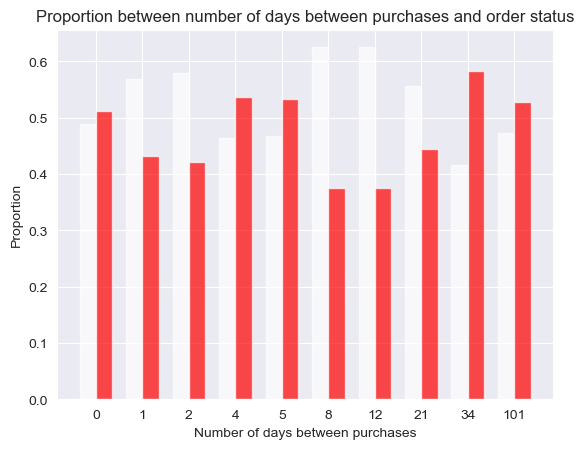

In [ ]:
proportions_lists
ind_new
for i in range(len(ind_new)):
    plt.bar(ind_new[i][0], proportions_lists[i][True], width, color='w', alpha=.7, label='Accepted Order')
    plt.bar(ind_new[i][1], proportions_lists[i][False], width, color='r', alpha=.7, label='Refunded Order')
    
# # title and labels
plt.ylabel('Proportion')
plt.xlabel('Number of days between purchases')
plt.title('Proportion between number of days between purchases and order status')
locations = ind + width / 2  # xtick locations
# labels = ['3', '4', '5', '6', '7', '8', '9']  # xtick labels
labels = ['0', '1', '2', '4', '5', '8', '12', '21', '34', '101']

plt.xticks(locations, labels)

# # legend
# plt.legend()


In [ ]:
sns.set_style('darkgrid')
# plot bars
accepted_bars = plt.bar(ind, accepted_proportions, width, color='r', alpha=.7, label='Accepted Order')
returned_bars = plt.bar(ind + width, refunded_proportions, width, color='w', alpha=.7, label='Refunded Order')

# # title and labels
plt.ylabel('Proportion')
plt.xlabel('Number of days between purchases')
plt.title('Proportion between number of days between purchases and order status')
locations = ind + width / 2  # xtick locations
# labels = ['3', '4', '5', '6', '7', '8', '9']  # xtick labels
labels = ['0', '1', '2', '4', '5', '8', '12', '21', '34', '101']

plt.xticks(locations, labels)

# # legend
plt.legend()


In [ ]:
# original********************************************************************************************************************************
# get total counts for each color
status_totals = at_least_2_df.groupby('purchase_1').count()['buyer_phone']
status_totals

purchase_1
False    171
True     189
Name: buyer_phone, dtype: int64

In [ ]:
# get counts for each rating and color
status_counts = at_least_2_df.groupby(['purchase_1', 'date_diff_1_levels']).count()['buyer_phone']
status_counts

purchase_1  date_diff_1_levels
False       0                     23
            1                     19
            2                      8
            4                     22
            5                     16
            8                     15
            12                    12
            21                    16
            34                    21
            101                   19
True        0                     22
            1                     25
            2                     11
            4                     19
            5                     14
            8                     25
            12                    20
            21                    20
            34                    15
            101                   17
Name: buyer_phone, dtype: int64

In [ ]:
# get proportions by dividing red rating counts by total # of red samples
accepted_proportions = status_counts[True] / status_totals[True]
accepted_proportions

date_diff_1_levels
0      0.116402
1      0.132275
2      0.058201
4      0.100529
5      0.074074
8      0.132275
12     0.105820
21     0.105820
34     0.079365
101    0.089947
Name: buyer_phone, dtype: float64

In [ ]:
# get proportions by dividing red rating counts by total # of red samples
refunded_proportions = status_counts[False] / status_totals[False]
refunded_proportions

date_diff_1_levels
0      0.134503
1      0.111111
2      0.046784
4      0.128655
5      0.093567
8      0.087719
12     0.070175
21     0.093567
34     0.122807
101    0.111111
Name: buyer_phone, dtype: float64

In [ ]:
ind = np.arange(len(accepted_proportions))  # the x locations for the groups
width = 0.35       # the width of the bars
ind

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

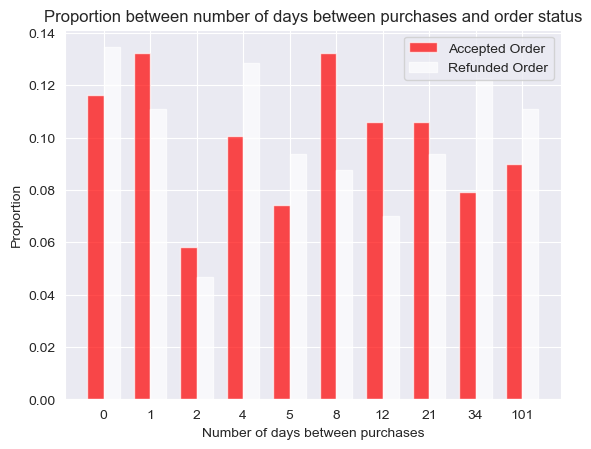

In [ ]:
sns.set_style('darkgrid')
# plot bars
accepted_bars = plt.bar(ind, accepted_proportions, width, color='r', alpha=.7, label='Accepted Order')
returned_bars = plt.bar(ind + width, refunded_proportions, width, color='w', alpha=.7, label='Refunded Order')

# # title and labels
plt.ylabel('Proportion')
plt.xlabel('Number of days between purchases')
plt.title('Proportion between number of days between purchases and order status')
locations = ind + width / 2  # xtick locations
# labels = ['3', '4', '5', '6', '7', '8', '9']  # xtick labels
labels = ['0', '1', '2', '4', '5', '8', '12', '21', '34', '101']

plt.xticks(locations, labels)

# # legend
plt.legend()


In [ ]:
transactions
customers
diffrences_df
purchase_df
joined_df
at_least_2_df
first_purchase_df

In [ ]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2957 entries, 0 to 2956
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           2957 non-null   int64         
 1   date         2957 non-null   datetime64[ns]
 2   status       2957 non-null   object        
 3   buyer_phone  2957 non-null   int64         
 4   buyer_city   2957 non-null   object        
 5   grand_total  2957 non-null   float64       
 6   purchase_1   2957 non-null   object        
 7   purchase_2   1179 non-null   object        
 8   purchase_3   721 non-null    object        
 9   day_of_week  2957 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 254.1+ KB


In [ ]:
# purchase_df.date.dt.day_of_week.value_counts().sort_index() 
purchase_df['day_of_week'] = purchase_df.date.dt.day_of_week


In [ ]:
purchase_df.groupby('day_of_week').count()['ID']

day_of_week
0    319
1    290
2    438
3    545
4    459
5    441
6    465
Name: ID, dtype: int64

In [ ]:
purchase_df.groupby(['day_of_week']).mean()['grand_total']

day_of_week
0    6785.645944
1    7272.771714
2    6709.732226
3    6455.692090
4    7389.036542
5    7026.506973
6    6771.278839
Name: grand_total, dtype: float64

In [ ]:
purchase_df.groupby(['day_of_week']).count()['ID']

day_of_week
0    319
1    290
2    438
3    545
4    459
5    441
6    465
Name: ID, dtype: int64

In [ ]:
purchase_df.groupby(['buyer_city']).mean()['makes_second_purchase'].sort_index()

buyer_city
Abha            0.454545
Al Baha         0.373134
Al Qassim       0.385906
Dammam          0.320261
Jeddah          0.421053
Khobar          0.385714
Makkah          0.411765
Rafha           0.429577
Ras Tannurah    0.395833
Riyadh          0.407972
Skakah          0.425926
Tabuk           0.350993
Taif            0.388158
Name: makes_second_purchase, dtype: float64

In [ ]:
purchase_df_unique.groupby(['buyer_city']).mean()['makes_second_purchase'].sort_index()

buyer_city
Abha            0.264151
Al Baha         0.160000
Al Qassim       0.160550
Dammam          0.133333
Jeddah          0.161017
Khobar          0.173077
Makkah          0.180328
Rafha           0.129032
Ras Tannurah    0.151220
Riyadh          0.174837
Skakah          0.198276
Tabuk           0.140351
Taif            0.154545
Name: makes_second_purchase, dtype: float64

In [ ]:
third_purchase_rate = purchase_df_unique.loc[purchase_df_unique.makes_second_purchase].groupby(['buyer_city']).mean()['makes_third_purchase'].sort_index()
second_purchase_rate = purchase_df_unique.groupby(['buyer_city']).mean()['makes_second_purchase'].sort_index()
second_purchase_rate

buyer_city
Abha            0.264151
Al Baha         0.160000
Al Qassim       0.160550
Dammam          0.133333
Jeddah          0.161017
Khobar          0.173077
Makkah          0.180328
Rafha           0.129032
Ras Tannurah    0.151220
Riyadh          0.174837
Skakah          0.198276
Tabuk           0.140351
Taif            0.154545
Name: makes_second_purchase, dtype: float64

In [ ]:
sales = purchase_df_unique.groupby(['buyer_city']).count()['ID'].sort_index()
sales.shape

(13,)

In [ ]:
purchase_df_unique.loc[purchase_df_unique.makes_second_purchase].groupby(['buyer_city']).sum()['makes_third_purchase'].sort_index()

buyer_city
Abha            12
Al Baha          6
Al Qassim       14
Dammam           8
Jeddah           4
Khobar           8
Makkah          10
Rafha            6
Ras Tannurah     9
Riyadh          32
Skakah          10
Tabuk            6
Taif             6
Name: makes_third_purchase, dtype: int64

In [ ]:
cities_populations = pd.read_csv("../../cities/worldcities.csv")
cities_populations.query("country == 'Saudi Arabia'")

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
84,Riyadh,Riyadh,24.6500,46.7100,Saudi Arabia,SA,SAU,Ar Riyāḑ,primary,6889000.0,1682999334
196,Jeddah,Jeddah,21.5428,39.1728,Saudi Arabia,SA,SAU,Makkah al Mukarramah,NaN,3976000.0,1682926944
436,Mecca,Mecca,21.4225,39.8261,Saudi Arabia,SA,SAU,Makkah al Mukarramah,admin,1675368.0,1682169241
581,Medina,Medina,24.4667,39.6000,Saudi Arabia,SA,SAU,Al Madīnah al Munawwarah,admin,1180770.0,1682345785
912,Ad Dammām,Ad Dammam,26.4333,50.1000,Saudi Arabia,SA,SAU,Ash Sharqīyah,admin,903312.0,1682452296
1128,Al Hufūf,Al Hufuf,25.3608,49.5997,Saudi Arabia,SA,SAU,Ash Sharqīyah,NaN,660788.0,1682958157
1230,Al Ḩillah,Al Hillah,23.4895,46.7564,Saudi Arabia,SA,SAU,Ar Riyāḑ,NaN,594605.0,1682494753
1257,Aţ Ţā’if,At Ta'if,21.2667,40.4167,Saudi Arabia,SA,SAU,Makkah al Mukarramah,NaN,579970.0,1682956102
1309,Tabūk,Tabuk,28.3838,36.5550,Saudi Arabia,SA,SAU,Tabūk,admin,547957.0,1682590992
1494,Buraydah,Buraydah,26.3333,43.9667,Saudi Arabia,SA,SAU,Al Qaşīm,admin,467410.0,1682470726


In [ ]:
purchase_df_unique.buyer_city.unique()
cities_population = [4000000, 7000000, 1500000, 1500000, 65000, 600000, 22000, 1700000, 230000, 1100000, 550000, 150000, 240000]

In [ ]:
cities_populations.merge(purchase_df_unique, 'right', left_on='city_ascii', right_on='buyer_city')

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,...,buyer_city,grand_total,purchase_1,purchase_2,purchase_3,makes_second_purchase,purchase_1_status,purchase_2_status,purchase_3_status,makes_third_purchase
0,Jeddah,Jeddah,21.5428,39.1728,Saudi Arabia,SA,SAU,Makkah al Mukarramah,NaN,3976000.0,...,Jeddah,4332.000,False,None,None,False,Returned,None,None,False
1,Riyadh,Riyadh,24.6500,46.7100,Saudi Arabia,SA,SAU,Ar Riyāḑ,primary,6889000.0,...,Riyadh,5425.830,True,None,None,False,Accepted,None,None,False
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Khobar,30.153,False,None,None,False,Returned,None,None,False
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Dammam,20795.766,False,None,None,False,Returned,None,None,False
4,Rafḩā,Rafha,29.6202,43.4948,Saudi Arabia,SA,SAU,Al Ḩudūd ash Shamālīyah,NaN,64755.0,...,Rafha,5033.157,False,None,None,False,Returned,None,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361,Jeddah,Jeddah,21.5428,39.1728,Saudi Arabia,SA,SAU,Makkah al Mukarramah,NaN,3976000.0,...,Jeddah,8961.825,True,None,None,False,Accepted,None,None,False
2362,Tabūk,Tabuk,28.3838,36.5550,Saudi Arabia,SA,SAU,Tabūk,admin,547957.0,...,Tabuk,10830.000,False,None,None,False,Returned,None,None,False
2363,Tabuk,Tabuk,17.4500,121.4583,Philippines,PH,PHL,Kalinga,NaN,121033.0,...,Tabuk,10830.000,False,None,None,False,Returned,None,None,False
2364,Tabuk,Tabuk,17.4084,121.2785,Philippines,PH,PHL,Kalinga,admin,NaN,...,Tabuk,10830.000,False,None,None,False,Returned,None,None,False


In [ ]:
purchase_df_unique.buyer_city.unique()


array(['Jeddah', 'Riyadh', 'Khobar', 'Dammam', 'Rafha', 'Taif', 'Al Baha',
       'Makkah', 'Abha', 'Al Qassim', 'Tabuk', 'Ras Tannurah', 'Skakah'],
      dtype=object)

Text(0.5, 0, 'number of unique customers in a city')

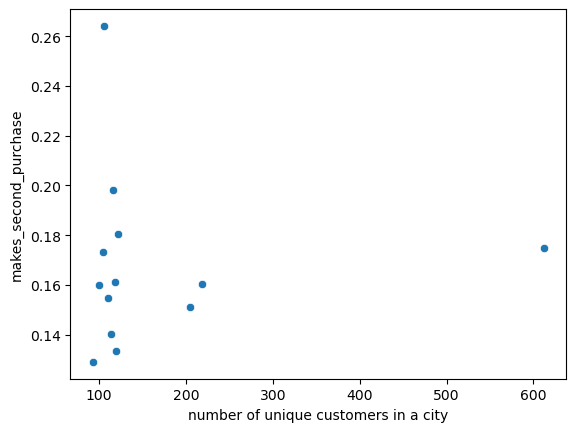

In [ ]:
sns.scatterplot(sales, second_purchase_rate)
plt.xlabel('number of unique customers in a city')
# plt.ylabel('


<AxesSubplot:xlabel='ID', ylabel='makes_second_purchase'>

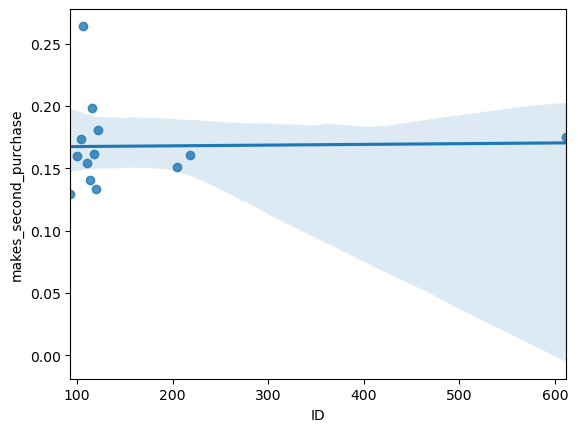

In [ ]:
sns.regplot(sales, second_purchase_rate)

In [ ]:
np.corrcoef(second_purchase_rate, third_purchase_rate)

array([[1.       , 0.0365304],
       [0.0365304, 1.       ]])

In [ ]:
second_purchase_rate.corr(third_purchase_rate)

0.03653039500453492

In [ ]:
sales[['Jeddah', 'Riyadh', 'Khobar', 'Dammam', 'Rafha', 'Taif', 'Al Baha',
       'Makkah', 'Abha', 'Al Qassim', 'Tabuk', 'Ras Tannurah', 'Skakah']]
cities_population
np.corrcoef(cities_population, sales[['Jeddah', 'Riyadh', 'Khobar', 'Dammam', 'Rafha', 'Taif', 'Al Baha',
       'Makkah', 'Abha', 'Al Qassim', 'Tabuk', 'Ras Tannurah', 'Skakah']])

array([[1.        , 0.80442367],
       [0.80442367, 1.        ]])

<AxesSubplot:ylabel='ID'>

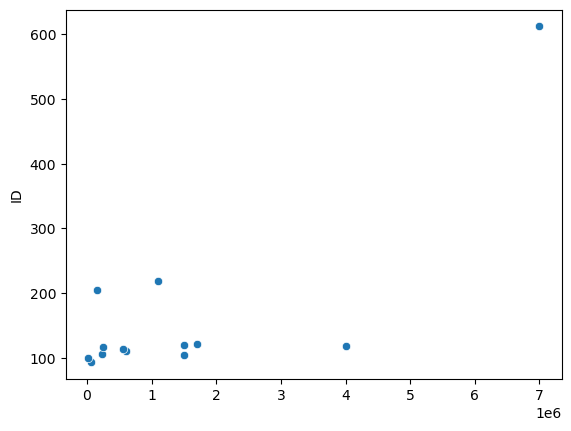

In [ ]:
sns.scatterplot(cities_population, sales[['Jeddah', 'Riyadh', 'Khobar', 'Dammam', 'Rafha', 'Taif', 'Al Baha',
       'Makkah', 'Abha', 'Al Qassim', 'Tabuk', 'Ras Tannurah', 'Skakah']])

In [ ]:
import plotly.express as px
px.scatter(x=third_purchase_rate, y=second_purchase_rate, trendline='ols')

<AxesSubplot:ylabel='ID'>

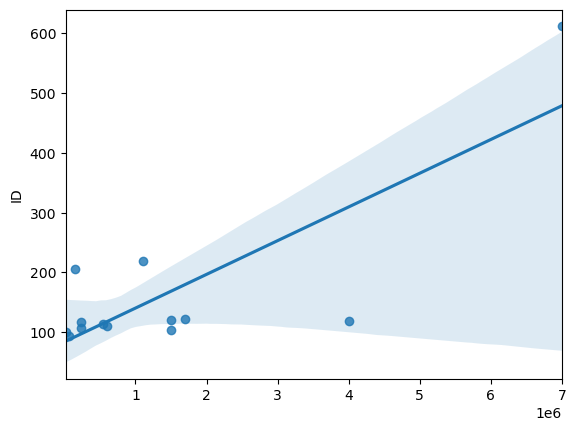

In [ ]:

sns.regplot(cities_population, sales[['Jeddah', 'Riyadh', 'Khobar', 'Dammam', 'Rafha', 'Taif', 'Al Baha',
       'Makkah', 'Abha', 'Al Qassim', 'Tabuk', 'Ras Tannurah', 'Skakah']])